# A Summed Probability Analysis of inscriptions from the Latin-speaking Roman Empire

## Introduction

This project aims to apply summed probability analysis (SPA) to Latin inscriptions. For decades, SPA has been applied to radiocarbon dates in archaeology. SPA relies on the fact that each date represtents data about human occupation, and so tallying them provides insights into demographic changes (i.e., more radiocarbon dates equals more people). Problems with SPA using radiocarbon dates are addressed through use of the large datasets and thoughtful statistical approaches. 

Like radiocarbon dates, inscriptions provide a data-point: a place and a date of human activity. Also like radiocarbon dates, inscription dates come with temporal uncertainty, and are subject to the vagaries of preservation. Inscriptions have the advantage, however, of directly representing a human act in the past (the placing of an inscription), not just the taking of a sample by a modern researcher that may or may not be related to past human activity. 

## Dataset

The dataset used for this analysis is Latin Inscriptions of the Roman Empire (LIRE; https://doi.org/10.5281/zenodo.8147298), which has been compiled and cleaned from various digital inscription corpora by the SDAM group at Aarhus University, Denmark. It contains over 182,000 inscriptions dating from 50 BC - AD 350. 

If this analysis proves successful, I will consider expanding it to the Latin Inscriptions in Space and Time (LIST) dataset, which requires additional cleaning but extends the data forward past AD 350, perhaps helping to clarify 4th-century trends.

## Approach

After some initial (minor) cleaning and the addition of a 'date_range' column (subtracting 'not_before' from 'not_after' for each inscription) and a 'province_language' column (to identify primarily Latin-speaking provinces), a series of statistical steps are undertaken:

1. Generate descriptive statistics of date ranges, including inscription counts under certain date-range thresholds, to get an idea of how much termporal uncertainty exists in the dataset.
2. Explore the minimum sample size needed for SPA when examining spatially, temporally, or otherwise limited subsets of the data, ensuring this sample size remains representative.
3. Run SPA of the entire dataset, including under various date-range thresholds and sample sizes, to shed light on the trade-offs between sample size and temporal uncertainty.
4. Run SPA on various subsets of the data:
* Latin-speaking empire with and without Roma
* Each province
* Each urban area
5. Reproduce Hanson's results showing statistically significant relationship between independent calculation of urban area population and inscription count.
* Characterise the strength and explanatory power of this relationship.
* Re-run this correlation analysis using letter count, not just inscription count, to test Hanson's information content theory explaining the relationship between population and inscription count.
* Check to see if the letter count approach correlates more or less than the inscription count approach to population.
6. Re-run the SPA using letter count..
7. Calculate urban area, province, and empire population changes between AD 1 - 300 using either inscription count or letter count, depending on which looks most plausible.

## Results


## Discussion



*ChatGPT-4 used throughout to generate code snippets*

# Setup

## Install libraries

geopandas, fastparquet, numpy

In [3]:
# in jupyter notebooks, normal install using !pip install doesn't work, use the solution from:
# https://www.geeksforgeeks.org/install-python-package-using-jupyter-notebook/

import sys
!{sys.executable} -m pip install -r requirements.txt

In [27]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import fastparquet
import tempun # Vojtek's code to model temporal uncertainty
import random
import os # for saving and loading bootstrap samples
import re # for regular expressions to fix bootsrtap filenames
import hashlib # for generating hashes for bootstrap sample filenames
import statsmodels.api as sm # For OLS regression and other statistics
import scipy.stats as stats # For Spearman's Rank Correlation and non-normal distributions
import pickle  # Importing pickle for serialization

from sklearn.metrics import mean_squared_error
from scipy.ndimage import uniform_filter1d  # For more efficient moving average calculation
from tqdm.auto import tqdm # For adding a progress bar to lengthy operations; tqdm.aut automatically adapts to the environment it is run it to provide a GUI-based progress bar where possible
from statsmodels.sandbox.regression.predstd import wls_prediction_std # to compute the prediction standard errors 
from statsmodels.discrete.discrete_model import NegativeBinomial # for bootstrapped Negative Binomial Regresson

import seaborn as sns

import tabulate

## Import LIRE_v2.3 dataset 

**Dataset DOI**: https://doi.org/10.5281/zenodo.8147298 

**Version**: 2.3 (14 July 2023)

**Format**: parquet

**License**: CC-BY-4.0

**Cite as**: Kaše, Vojtěch, Heřmánková, Petra, & Sobotková, Adéla. (2023). LIRE (v2.3) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.8147298

In [9]:
lire = gpd.read_parquet('data/LIRE_v2-3.parquet')

### Display first five rows of LIRE dataset

In [10]:
lire.head(5)

,LIST-ID,EDCS-ID,EDH-ID,trismegistos_uri,pleiades_id,transcription,inscription,clean_text_conservative,clean_text_interpretive_sentence,clean_text_interpretive_word,...,not_before,Longitude,Latitude,geotemporal?,geometry,urban_context,urban_context_city,urban_context_pop_est,type_of_inscription_auto,type_of_inscription_auto_prob
445464,445465,EDCS-03700724,HD052964,https://www.trismegistos.org/text/121715,531064,Fortissimo et piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Fortissimo et piissimo Caesari domino nostro G...,...,309.0,20.766800,39.451200,True,POINT (20.767 39.451),rural,None,NaN,honorific inscription,1.0
445466,445467,EDCS-03300852,HD051000,https://www.trismegistos.org/text/177273,240855,[Imp(eratori) Caes(ari) M(arco)] / An[nio] Flo...,Imp(eratori) / Floriano / P(io) F(elici) Aug(u...,An Floriano P F Aug p p m p III Imp Caes M Aur...,Imperatori Caesari Marco Annio Floriano Pio Fe...,Imperatori Caesari Marco Annio Floriano Pio Fe...,...,276.0,22.417100,37.431900,True,POINT (22.417 37.432),large,Tegea,46362.0,mile-/leaguestone,1.0
445467,445468,EDCS-28500283,HD021396,https://www.trismegistos.org/text/177131,,T[i(berius)] Claudius Caesar Aug(ustus) / G[er...,T[(iberius)] Claudius Caesar Aug(ustus) / G[er...,T Claudius Caesar Aug Ganicus pontif max trib ...,Tiberius Claudius Caesar Augustus Germanicus p...,Tiberius Claudius Caesar Augustus Germanicus p...,...,49.0,22.420877,37.454501,True,POINT (22.421 37.455),large,Tegea,46362.0,public legal inscription,1.0
445469,445470,EDCS-09400671,HD011892,https://www.trismegistos.org/text/177087,,Pro salute Imp(eratorum) Caesari(s) / L(uci) S...,Pro salute Imp(eratoris) Caesari(s) / L(uci) S...,Pro salute Imp Caesari L Septimi Severi et M A...,Pro salute Imperatorum Caesaris Luci Septimi S...,Pro salute Imperatorum Caesaris Luci Septimi S...,...,198.0,24.937637,37.837612,True,POINT (24.938 37.838),rural,None,NaN,votive inscription,1.0
445471,445472,EDCS-24600769,HD050999,https://www.trismegistos.org/text/177272,570531,Octa(vius) Sal(utaris),Octa(vius) Sa(lutaris),Octa Sal,Octavius Salutaris,Octavius Salutaris,...,81.0,21.627100,37.647900,True,POINT (21.627 37.648),rural,None,NaN,owner/artist inscription,1.0


### Display column names

Also set column names as a variable so that column names can be used later.

In [11]:
lire_columns = lire.columns
print("\n".join(lire_columns))

LIST-ID
EDCS-ID
EDH-ID
trismegistos_uri
pleiades_id
transcription
inscription
clean_text_conservative
clean_text_interpretive_sentence
clean_text_interpretive_word
clean_text_interpretive_word_EDCS
diplomatic_text
province
place
inscr_type
status_notation
inscr_process
status
partner_link
last_update
letter_size
type_of_inscription
work_status
year_of_find
present_location
text_edition
support_objecttype
support_material
support_decoration
keywords_term
people
type_of_inscription_clean
type_of_inscription_certainty
height_cm
width_cm
depth_cm
material_clean
type_of_monument_clean
type_of_monument_certainty
province_label_clean
province_label_certainty
country_clean
country_certainty
findspot_ancient_clean
findspot_ancient_certainty
modern_region_clean
modern_region_certainty
findspot_modern_clean
findspot_modern_certainty
findspot_clean
findspot_certainty
language
language_EDCS
raw_dating
not_after
not_before
Longitude
Latitude
geotemporal?
geometry
urban_context
urban_context_city
urb

## Clean data

The quality of the dataset is good, but I found some errors where the date range is negative. This block of code lists any inscriptions where the 'not_before' date is greater than 'not_after' date.

### Identify records with a date range less than zero

In [40]:
# Filter records where date_range is less than 0
error_rows = lire[lire['not_before'] > lire['not_after']]

# Display only specific columns for the filtered records
print(error_rows[['LIST-ID', 'raw_dating', 'not_before', 'not_after']])

error_rows.to_csv("error_rows", index=False)

Empty DataFrame
Columns: [LIST-ID, raw_dating, not_before, not_after]
Index: []


### Swap the 'not_before' and 'not_after' values to resolve negative date-range error

For any rows where the 'not_before' date is greater than the 'not_after' date (yielding a negative date range), reverse the dates. This solution assumes transposition as the source of the error, which seems to be the cause of the problem in most cases, when looking at the problematic records. In some cases the 'not_before' and 'not_after' dates do not match the 'raw_dating' values; I need to ask the dataset authors if these changes are intentional or not.

In [13]:
# Define a function to swap 'not_before' and 'not_after' when 'not_before' > 'not_after'
def swap_dates(row):
    if row['not_before'] > row['not_after']:
        row['not_before'], row['not_after'] = row['not_after'], row['not_before']
    return row

# Apply the function to swap the dates
lire = lire.apply(swap_dates, axis=1)

## Add ``date_range`` column

SPA operates on an inscription's date range, calculated by subtracting the earliest possible date for the inscription ('not_before') from the latest possible date ('not-after'). 

This block of code checcks to see if a 'date_range' column already exists, and calculates one if it does not.

In [14]:
# Check if the 'date_range' column already exists
if 'date_range' not in lire.columns:
    # If it doesn't exist, calculate date range for each inscription and add it to the LIRE dataframe
    lire['date_range'] = lire['not_after'] - lire['not_before']
    # Show the updated DataFrame to check that the new column has been added successfully
    print("date_range column added.")
    # print(lire.head()) # Option to print the first few records of the dataset to confirm
else:
    print("date_range column already exists.")

date_range column added.


## Add a ``province_language`` column

This dataset contains mostly Latin inscriptions. As a result, inscription counts mean something different in Latin-speaking provinces versus Greek-speaking provinces. Here I assume that Latin inscriptions are more representative of demographics in Latin-speaking provinces, whereas they represent particular types of official activities, displays of Roman identity, or other more restricted meanings in Greak-speaking provinces. Counts of Latin inscriptions, moreover, are lower in Greek-speaking provinces.

This code designates each province as Latin or Greek speaking, and adds that information in a new column, so that Latin-speaking provinces can be analysed separately.

In [15]:
# Create a dictionary mapping each province to its primary language
province_language_map = {
    'Roma': 'Latin',
    'Latium et Campania / Regio I': 'Latin',
    'Dalmatia': 'Latin',
    'Hispania citerior': 'Latin',
    'Germania superior': 'Latin',
    'Venetia et Histria / Regio X': 'Latin',
    'Dacia': 'Latin',
    'Britannia': 'Latin',
    'Pannonia superior': 'Latin',
    'Samnium / Regio IV': 'Latin',
    'Africa proconsularis': 'Latin',
    'Germania inferior': 'Latin',
    'Apulia et Calabria / Regio II': 'Latin',
    'Pannonia inferior': 'Latin',
    'Numidia': 'Latin',
    'Etruria / Regio VII': 'Latin',
    'Umbria / Regio VI': 'Latin',
    'Noricum': 'Latin',
    'Baetica': 'Latin',
    'Transpadana / Regio XI': 'Latin',
    'Moesia inferior': 'Latin',
    'Lusitania': 'Latin',
    'Moesia superior': 'Latin',
    'Sardinia': 'Latin',
    'Belgica': 'Latin',
    'Gallia Narbonensis': 'Latin',
    'Aemilia / Regio VIII': 'Latin',
    'Picenum / Regio V': 'Latin',
    'Raetia': 'Latin',
    'Macedonia': 'Greek',
    'Aquitani(c)a': 'Latin',
    'Bruttium et Lucania / Regio III': 'Latin',
    'Liguria / Regio IX': 'Latin',
    'Lugudunensis': 'Latin',
    'Mauretania Caesariensis': 'Latin',
    'Asia': 'Greek',
    'Belgica | Germania superior': 'Latin',
    'Sicilia': 'Latin',
    'Syria': 'Greek',
    'Achaia': 'Greek',
    'Alpes Cottiae': 'Latin',
    'Alpes Maritimae': 'Latin',
    'Galatia': 'Greek',
    'Thracia': 'Greek',
    'Aegyptus': 'Greek'
}

# Check if the 'province_language' column already exists
if 'province_language' not in lire.columns:
    # If it doesn't exist, add a new column to the DataFrame, 'province_language', 
    # mapping the province to its primary language
    lire['province_language'] = lire['province'].map(province_language_map)
    # Show the updated DataFrame to check that the new column has been added successfully
    print("province_language column added.")
    # print(lire.head()) # Option to print the first few records of the dataset to confirm
else:
    print("province_language column already exists.")

province_language column added.


# Exploring the LIRE dataset

## Calculate descriptive statistics for date ranges

Display the total number of records, average date range, median date range, and standard deviation of date range.

In [16]:
# Return the total number of records
total_records = lire.shape[0]

# Calculate the average date range
average_range = lire['date_range'].mean()

# Calculate the median date range
median_range = lire['date_range'].median()

# Calculate the standard deviation of the date range
std_dev_range = lire['date_range'].std()

# Display results
print(f"Total number of records: {total_records}")
print(f"Average Date Range: {average_range}")
print(f"Median Date Range: {median_range}")
print(f"Standard Deviation of Date Range: {std_dev_range}")

Total number of records: 182852
Average Date Range: 101.28705182333253
Median Date Range: 99.0
Standard Deviation of Date Range: 76.75115026798449


## Create a histogram of date ranges

Using 10-year bins, create a historgram of date ranges.

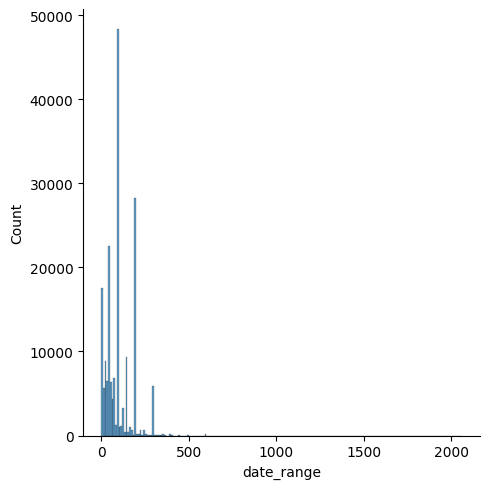

In [24]:

snsplot = sns.displot(lire, x="date_range", bins=np.arange(0, lire['date_range'].max() + 10, 10), edgecolor='black', alpha=0.7)


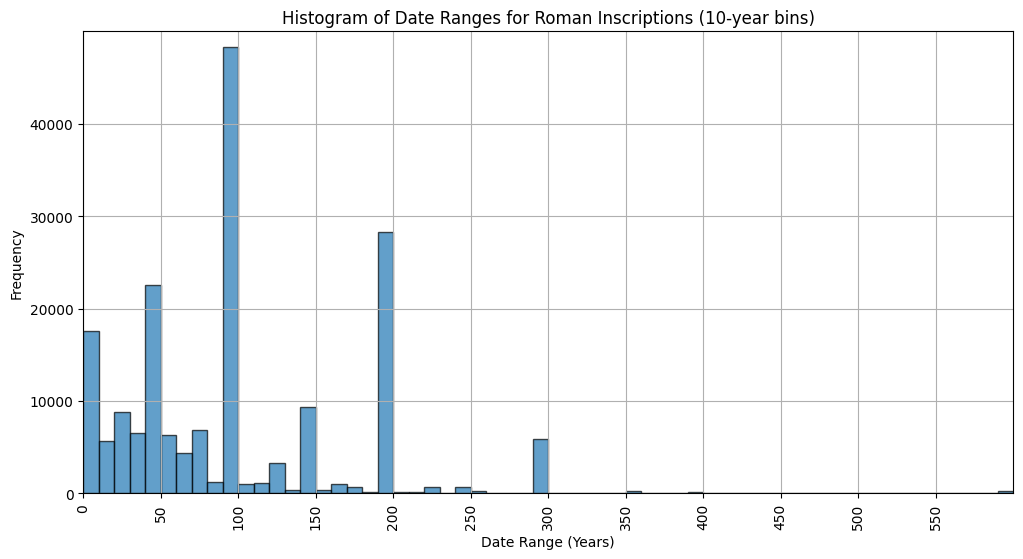

In [23]:


# Create the histogram
plt.figure(figsize=(12, 6))
plt.hist(lire['date_range'], bins=np.arange(0, lire['date_range'].max() + 10, 10), edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Date Range (Years)')
plt.ylabel('Frequency')
plt.title('Histogram of Date Ranges for Roman Inscriptions (10-year bins)')

# set axis limits and grid
plt.xlim([0, 600])
plt.ylim([0, 50000])
plt.grid(True)
plt.xticks(np.arange(0, 600, 50), rotation='vertical')  # Change 10 to the desired tick interval for the x-axis
plt.yticks(np.arange(0, 50000, 10000))  # Change 500 to the desired tick interval for the y-axis

# Show the plot
plt.show()

### Discussion: descriptive statitics and histogram

The dataset has over 182k records. The median and average date range are close (101.3 and 99.0 years respectively). The standard devation is high, at 76.75 years (coefficient of variation = 75.77), indicating a relatively high level of dispersion. **This dataset has high variability and many outliers**.

Inscription date-range has spikes at round numbers (e.g., 0-10, 40-50, 90-100, 140-150, 190-200, 290-300 - but not 240-250), reflecting that researchers who assigned approximate dates tended to choose such round numbers. Above 80 years, there are few inscriptions in bins other than the round-numbered ones. from 0-80 years, however, there are 1,000s of inscriptons in each bin (with spikes at 0-10 and 40-50). 

## Count number of inscriptions *between* various date-range thresholds

This code block calculates the number of inscriptions falling within certain date ranges, e.g., 0-1 year, 1-10 years, 10-25 years, etc., in order to get a sense of typical chronological uncertainty associated with the inscriptions, and a sense of the distribution of uncertainty.

In [42]:
# Define the thresholds
thresholds = [1, 10, 25, 50, 100, 200, 300] 

# Create bins using the thresholds
bins = [0] + thresholds + [lire['date_range'].max() + 1]

# Categorize the date ranges based on the bins
lire['date_range_bins'] = pd.cut(lire['date_range'], bins, right=False) # Count is right-exclusive

# Count the number of inscriptions in each bin
inscription_counts = lire['date_range_bins'].value_counts().sort_index()

# Display the counts
print("Counts of inscriptions with date ranges between certain thresholds:")
print(inscription_counts)

Counts of inscriptions with date ranges between certain thresholds:
date_range_bins
[0.0, 1.0)          8279
[1.0, 10.0)         9296
[10.0, 25.0)        8415
[25.0, 50.0)       35122
[50.0, 100.0)      67162
[100.0, 200.0)     45651
[200.0, 300.0)      7995
[300.0, 2060.0)      932
Name: count, dtype: int64


## Count number of inscriptions with date ranges *under* various thresholds

As above, but cumulative total of inscriptions under particular date-range thresholds (e.g., <1 year, <10 years, <25 years, etc.).

In [53]:
# Define the thresholds
thresholds = [1, 10, 25, 50, 100, 200, 300]

# Initialize an empty dictionary to store counts
cumulative_counts = {}

# Calculate counts for each threshold
for threshold in thresholds:
    count = len(lire[lire['date_range'] < threshold]) # counts are right-exclusive
    cumulative_counts[threshold] = count

# Display the counts
print("Cumulative counts of inscriptions with date ranges under various thresholds:")
for threshold, count in cumulative_counts.items():
    print(f"0-{threshold} years: {count}")

tabulate.tabulate(cumulative_counts.items(), tablefmt='html', headers=['Threshold (Years)', 'Count'], intfmt=",")

Cumulative counts of inscriptions with date ranges under various thresholds:
0-1 years: 8279
0-10 years: 17575
0-25 years: 25990
0-50 years: 61112
0-100 years: 128274
0-200 years: 173925
0-300 years: 181920


TypeError: 'int' object is not iterable

### Discussion: Date-range distribution

The single largest bin for date ranges is 50-100 years. The next largest bins are 25-50 years and 100-200 years. About two-thirds of inscriptions, however,have an uncertainty of 100 years or less. About one-third have an uncertainty of 50 years or less.  

## Preliminary SPA calculation, all inscriptions, uniform distribution, 10-year bins

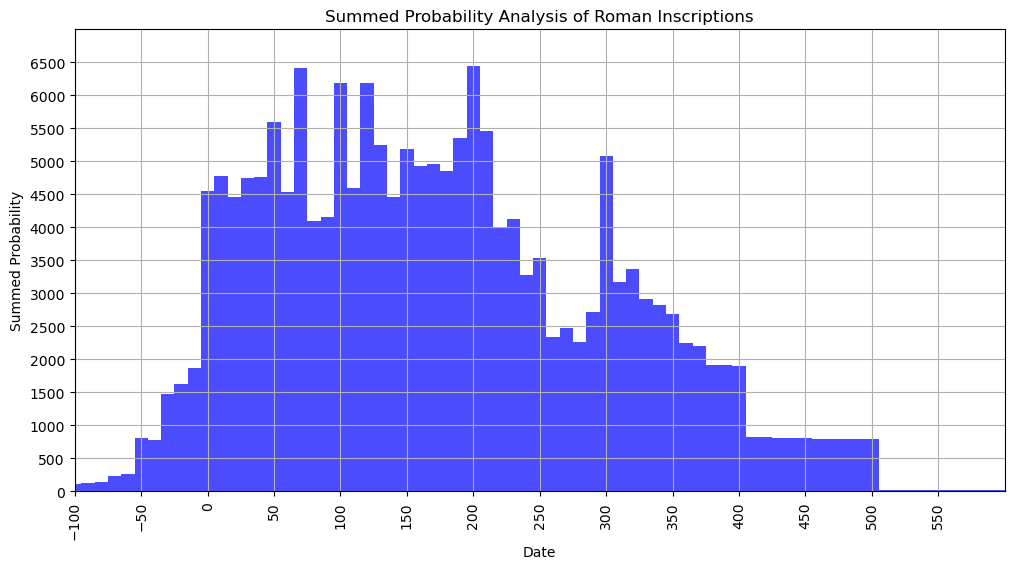

In [14]:
# Initialize the summed probability distribution
earliest_date = lire['not_before'].min()
latest_date = lire['not_after'].max()
resolution = 10 # Resolution defines the size of bins or segments in years

# Creat an array of zeros to hold the summed probabilities
num_bins = int((latest_date - earliest_date) / resolution) + 1
summed_prob = np.zeros(num_bins)

# Loop through each inscription to update the summed probability distribution
for index, row in lire.iterrows():
    start = row['not_before']
    end = row['not_after']
    
    start_idx = int((start - earliest_date) / resolution)
    end_idx = int((end - earliest_date) / resolution)
   
    # Calculate uniform distribution for this inscription,
    # accounting for date combinations that add up to zero
    try:
        uniform_prob = 1.0 / (end_idx - start_idx + 1)
    except ZeroDivisionError:
        uniform_prob = 1  # set default value here

    # Add this distribution to the overall summed distribution
    summed_prob[start_idx : end_idx + 1] += uniform_prob

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(np.arange(earliest_date, latest_date + resolution, resolution), summed_prob, width=resolution, color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Summed Probability')
plt.title('Summed Probability Analysis of Roman Inscriptions')

# set axis limits and grid
plt.xlim([-100, 600])
plt.ylim([0, 7000])
plt.grid(True)
plt.xticks(np.arange(-100, 600, 50), rotation='vertical')  # Change 10 to the desired tick interval for the x-axis
plt.yticks(np.arange(0, 7000, 500))  # Change 500 to the desired tick interval for the y-axis

# Show the plot
plt.show()

### Reflections

Looking at this overview plot:

* Several of the peaks seem to correspond to dynasty changes.
* Start date should probably be 1 AD
* End date should probably be 400 AD

# Minimum required sample size

## Calculate $\Delta$T: mean of date-range standard deviations

### Full dataset

In [15]:
# Calculate the date-range standard deviations for each record
lire['date_range_std_dev'] = (lire['not_after'] - lire['not_before']) / np.sqrt(12)  # Assuming uniform distribution

# Calculate the mean of these standard deviations
mean_std_dev = lire['date_range_std_dev'].mean()

print(f"The mean of the date-range standard deviations is: {mean_std_dev}")

The mean of the date-range standard deviations is: 29.239053317812306


### Various thresholds

In [16]:
# Define date range thresholds for filtering
thresholds = [25, 50, 100, 200, 300, float('inf')]

for threshold in thresholds:
    # Filter the data for records with a date range less than or equal to the current threshold
    filtered_lire = lire[lire['date_range'] <= threshold]
    
    # Calculate the date-range standard deviations for each record in the filtered DataFrame
    filtered_lire['date_range_std_dev'] = (filtered_lire['not_after'] - filtered_lire['not_before']) / np.sqrt(12)
    
    # Calculate the mean of these standard deviations in the filtered DataFrame
    mean_std_dev_filtered = filtered_lire['date_range_std_dev'].mean()
    
    # Count the number of records in the filtered DataFrame
    num_records_filtered = len(filtered_lire)
    
    print(f"For date range cut-off less than or equal to {threshold} years:")
    print(f"The mean of the date-range standard deviations is: {mean_std_dev_filtered}")
    print(f"The number of records in the filtered dataset is: {num_records_filtered}")
    print('-'*50)


For date range cut-off less than or equal to 25 years:
The mean of the date-range standard deviations is: 2.0145688928133385
The number of records in the filtered dataset is: 26162
--------------------------------------------------
For date range cut-off less than or equal to 50 years:
The mean of the date-range standard deviations is: 7.988212265149121
The number of records in the filtered dataset is: 61743
--------------------------------------------------


/home/shawn/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/shawn/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/shawn/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

For date range cut-off less than or equal to 100 years:
The mean of the date-range standard deviations is: 17.49287222466126
The number of records in the filtered dataset is: 128936
--------------------------------------------------
For date range cut-off less than or equal to 200 years:
The mean of the date-range standard deviations is: 26.33484949652472
The number of records in the filtered dataset is: 174095
--------------------------------------------------


/home/shawn/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


For date range cut-off less than or equal to 300 years:
The mean of the date-range standard deviations is: 28.73718320151814
The number of records in the filtered dataset is: 181925
--------------------------------------------------
For date range cut-off less than or equal to inf years:
The mean of the date-range standard deviations is: 29.239053317812306
The number of records in the filtered dataset is: 182852
--------------------------------------------------


### Reflections

Calculating the mean of date-range standard devations worked, and gives a rough idea of uncertainty on particular sample sizes. 

Now attempting to apply the approach suggested by Williams 2012.

## SE of the date-range mean via bootstrapping

None of my attempts to calculate MSE according to Willaims 2012 worked. Instead used the approach described at https://ealizadeh.com/blog/statistics-data-vs-sampling-distribution/. First compared the mean of date ranges in the sample to the mean of date ranges in the population, then compared to SP.

Loading saved bootstrap sample...
Loading saved bootstrap sample...
Loading saved bootstrap sample...
Loading saved bootstrap sample...
Loading saved bootstrap sample...
Loading saved bootstrap sample...
Loading saved bootstrap sample...
Mean date range for full dataset: 101.28705182333253
Standard Deviation of date range for full dataset: 76.75115026800985

For a sample size of 25:
  Mean date range for bootstrap samples: 101.64276000000001
  Standard Deviation of date range for bootstrap samples: 75.59364443189028
  Standard Error of the mean date range: 14.789060510471922

For a sample size of 50:
  Mean date range for bootstrap samples: 101.32762
  Standard Deviation of date range for bootstrap samples: 76.15881704126186
  Standard Error of the mean date range: 10.722454715950075

For a sample size of 100:
  Mean date range for bootstrap samples: 101.18972
  Standard Deviation of date range for bootstrap samples: 76.50871042471965
  Standard Error of the mean date range: 7.82940570

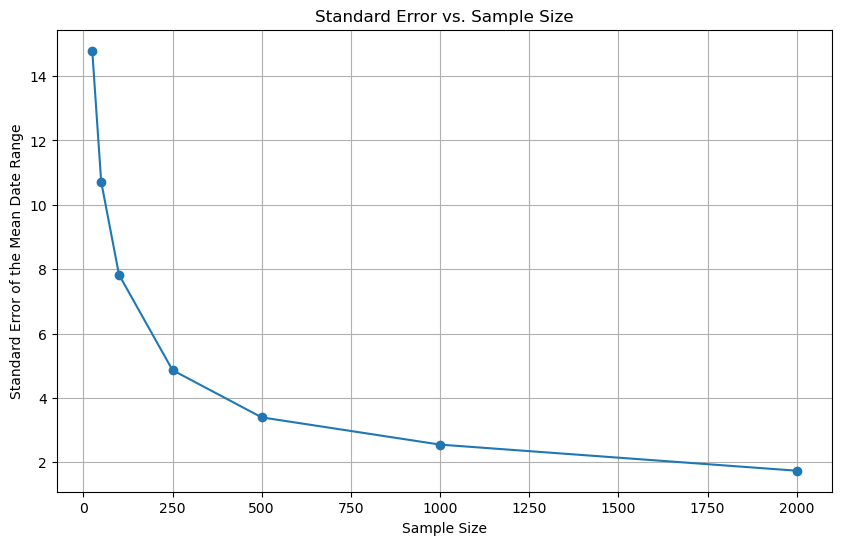

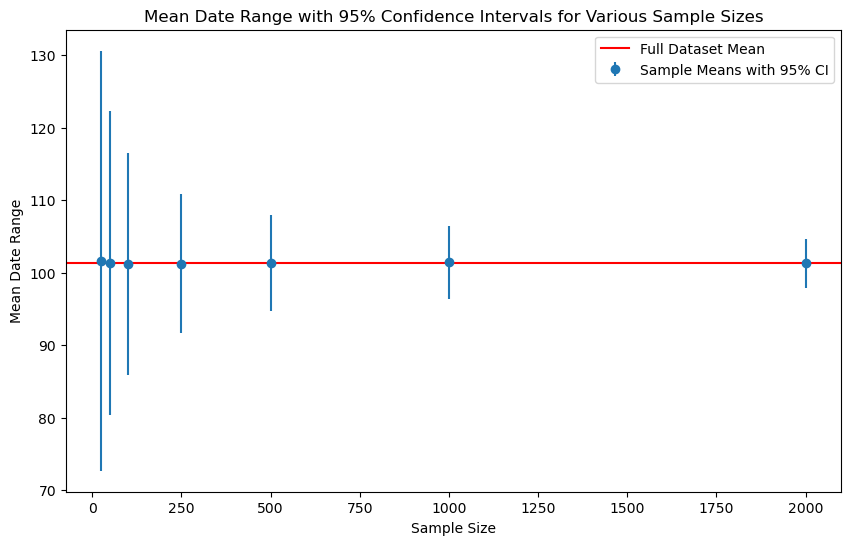

In [17]:
# Assuming lire is your DataFrame

# Number of bootstrap iterations
n_iterations = 1000

# Sample sizes to investigate
sample_sizes = [25, 50, 100, 250, 500, 1000, 2000]

# Initialize empty list to store standard error values for plotting
standard_errors = []

# New list to store the means for each sample size
sample_means = []

# Initialize empty dictionary to store results
results = {}

# Calculate mean and standard deviation of full dataset for comparison
mean_date_range_full = lire['date_range'].mean()
std_date_range_full = lire['date_range'].std()

# Make sure the directory for saving the bootstrap samples exists
if not os.path.exists("bootstrap-samples/standard-error/means_sd"):
    os.makedirs("bootstrap-samples/standard-error/means_sd", exist_ok=True)
    
# Loop through each sample size
for sample_size in sample_sizes:
    
    # Create a dynamic file name
    saved_sample_path = f"bootstrap-samples/standard-error/means_sd/n_{sample_size}.npy"
    
    if os.path.exists(saved_sample_path): # Check if saved bootstrap sample exists
        # Load saved sample
        print("Loading saved bootstrap sample...")
        saved_data = np.load(saved_sample_path, allow_pickle=True).item()
        bootstrap_sample_means = saved_data['means']
        bootstrap_sample_stds = saved_data['stds']
    else:
        # Create bootstrap sample
        print(f"Performing bootstrap operation for sample size {sample_size}...")
        bootstrap_sample_means = []
        bootstrap_sample_stds = []  
    
        # Bootstrap sampling
        for i in range(n_iterations):
            # Sample with replacement from the dataset
            bootstrap_sample = lire['date_range'].sample(n=sample_size, replace=True)
            # Calculate the mean of the bootstrap sample
            bootstrap_sample_mean = bootstrap_sample.mean()
            # Calculate the standard deviation of the bootstrap sample
            bootstrap_sample_std = bootstrap_sample.std()
            # Store the mean and standard deviation in their respective lists
            bootstrap_sample_means.append(bootstrap_sample_mean)
            bootstrap_sample_stds.append(bootstrap_sample_std)
            
        # Save the sample means and standard deviations
        print("Saving bootstrap sample means and standard deviations...")
        saved_data = {
            'means': bootstrap_sample_means,
            'stds': bootstrap_sample_stds
        }
        np.save(saved_sample_path, saved_data)
    
    # Calculate the standard error for the sample mean
    standard_error = np.std(bootstrap_sample_means)
    
    # Store the standard error for plotting
    standard_errors.append(standard_error)
    
    # Store the sample means for plotting
    sample_means.append(np.mean(bootstrap_sample_means))

    # Calculate the mean and standard deviation for the bootstrap samples
    mean_bootstrap_samples = np.mean(bootstrap_sample_means)
    std_bootstrap_samples = np.mean(bootstrap_sample_stds)

    # Store results in the dictionary
    results[sample_size] = {
        'mean_bootstrap_samples': mean_bootstrap_samples,
        'std_bootstrap_samples': std_bootstrap_samples,
        'standard_error': standard_error
    }

print(f"Mean date range for full dataset: {mean_date_range_full}")
print(f"Standard Deviation of date range for full dataset: {std_date_range_full}")

# Display the results
for sample_size, metrics in results.items():
    print(f"\nFor a sample size of {sample_size}:")
    print(f"  Mean date range for bootstrap samples: {metrics['mean_bootstrap_samples']}")
    print(f"  Standard Deviation of date range for bootstrap samples: {metrics['std_bootstrap_samples']}")
    print(f"  Standard Error of the mean date range: {metrics['standard_error']}")

# Plotting the standard errors
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, standard_errors, marker='o')
plt.xlabel('Sample Size')
plt.ylabel('Standard Error of the Mean Date Range')
plt.title('Standard Error vs. Sample Size')
plt.grid(True)
plt.show()

# Plot the means with confidence interval

# Calculate the 95% confidence intervals
lower_bound = np.array(sample_means) - 1.96 * np.array(standard_errors)
upper_bound = np.array(sample_means) + 1.96 * np.array(standard_errors)

# Plotting the mean and 95% CI
plt.figure(figsize=(10, 6))
plt.errorbar(sample_sizes, sample_means, yerr=[sample_means - lower_bound, upper_bound - sample_means], fmt='o', label='Sample Means with 95% CI')
plt.axhline(y=mean_date_range_full, color='r', linestyle='-', label='Full Dataset Mean') 
plt.xlabel('Sample Size')
plt.ylabel('Mean Date Range')
plt.title('Mean Date Range with 95% Confidence Intervals for Various Sample Sizes')
plt.legend()
plt.show()

### Kolmogorov-Smirnov test of 'date_range' subsets

Another view on minimum sample size for SPA

The D-statistic is the maximum difference between the CDFs of the two samples, and the P-value is the significance level. A smaller P-value would indicate that it is unlikely that the sample and the dataset come from the same distribution, assuming the null hypothesis is true.



In [18]:
from scipy import stats
import pandas as pd
import os

# Assuming lire is your DataFrame

# Sample sizes to investigate
sample_sizes = [25, 50, 100, 250, 500, 1000, 2000]

# Create a dictionary to hold Kolmogorov-Smirnov test results for each sample size
ks_results = {}

# Loop through each sample size
for sample_size in sample_sizes:

    # Sample without replacement from the dataset
    sample = lire['date_range'].sample(n=sample_size)
    
    # Perform the Kolmogorov-Smirnov test
    d_stat, p_value = stats.ks_2samp(sample, lire['date_range'])
    
    # Store the result in the dictionary
    ks_results[sample_size] = {
        'D-statistic': d_stat,
        'P-value': p_value
    }

# Display the results
for sample_size, metrics in ks_results.items():
    print(f"\nFor a sample size of {sample_size}:")
    print(f"  D-statistic: {metrics['D-statistic']}")
    print(f"  P-value: {metrics['P-value']}")



For a sample size of 25:
  D-statistic: 0.09746483494848293
  P-value: 0.9529712893262419

For a sample size of 50:
  D-statistic: 0.16121037779187541
  P-value: 0.13297660959299218

For a sample size of 100:
  D-statistic: 0.12143219653052745
  P-value: 0.09628169624582605

For a sample size of 250:
  D-statistic: 0.080716732658106
  P-value: 0.07278716419529596

For a sample size of 500:
  D-statistic: 0.03474503970424164
  P-value: 0.5712484801259562

For a sample size of 1000:
  D-statistic: 0.016535165051517087
  P-value: 0.9442303304424132

For a sample size of 2000:
  D-statistic: 0.025637892940738927
  P-value: 0.14591847322723772


#### K-S with bootstrapping

Performing K-S tests across sample sizes:   0%|          | 0/7 [00:00<?, ?it/s]

Generating bootstrap samples for n=25:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved bootstrap samples to bootstrap-samples/statistics/k_s-date_range/n_25.pkl


KS Test for n=25:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating bootstrap samples for n=50:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved bootstrap samples to bootstrap-samples/statistics/k_s-date_range/n_50.pkl


KS Test for n=50:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating bootstrap samples for n=100:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved bootstrap samples to bootstrap-samples/statistics/k_s-date_range/n_100.pkl


KS Test for n=100:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating bootstrap samples for n=250:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved bootstrap samples to bootstrap-samples/statistics/k_s-date_range/n_250.pkl


KS Test for n=250:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating bootstrap samples for n=500:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved bootstrap samples to bootstrap-samples/statistics/k_s-date_range/n_500.pkl


KS Test for n=500:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating bootstrap samples for n=1000:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved bootstrap samples to bootstrap-samples/statistics/k_s-date_range/n_1000.pkl


KS Test for n=1000:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating bootstrap samples for n=2000:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved bootstrap samples to bootstrap-samples/statistics/k_s-date_range/n_2000.pkl


KS Test for n=2000:   0%|          | 0/1000 [00:00<?, ?it/s]

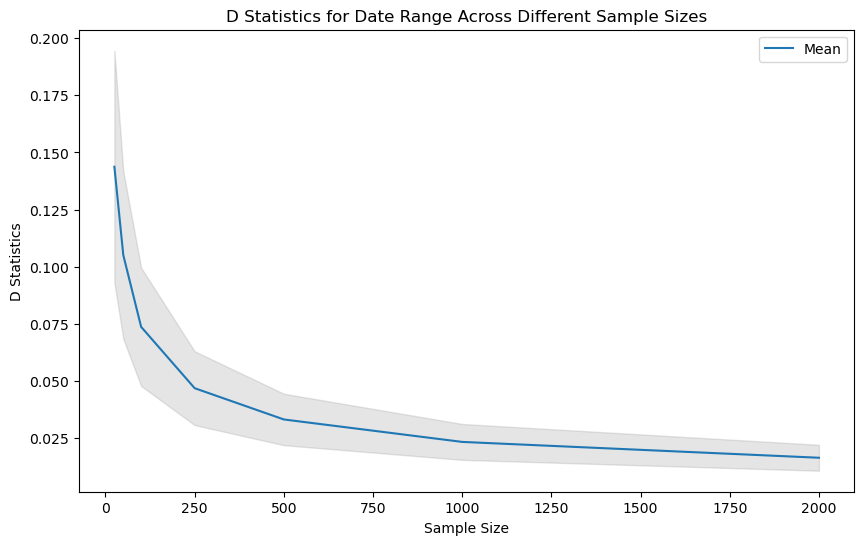

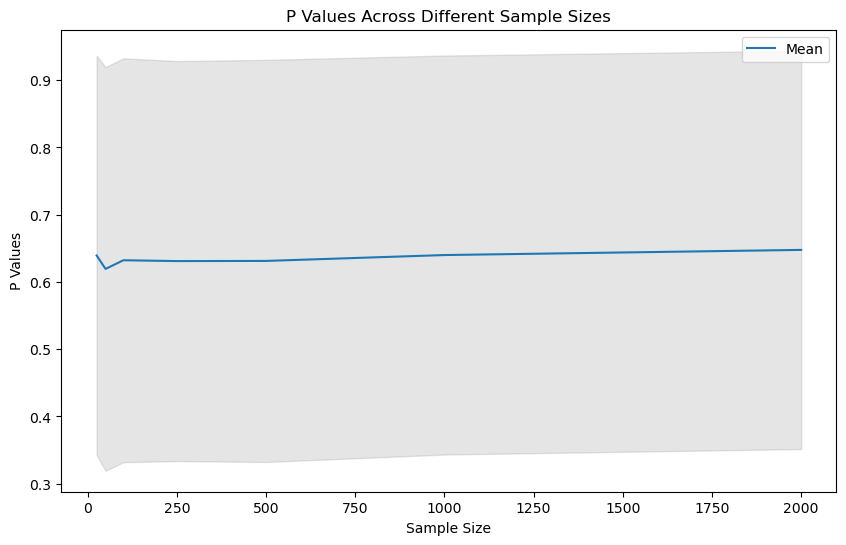

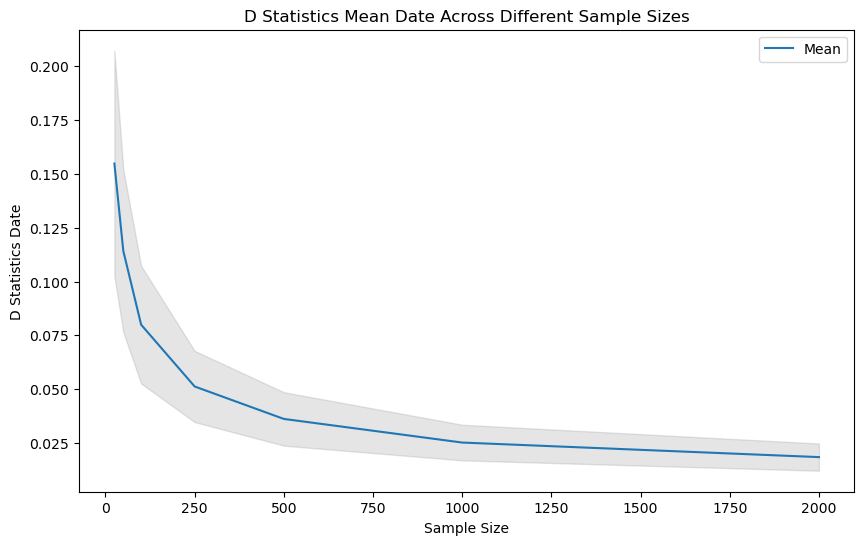

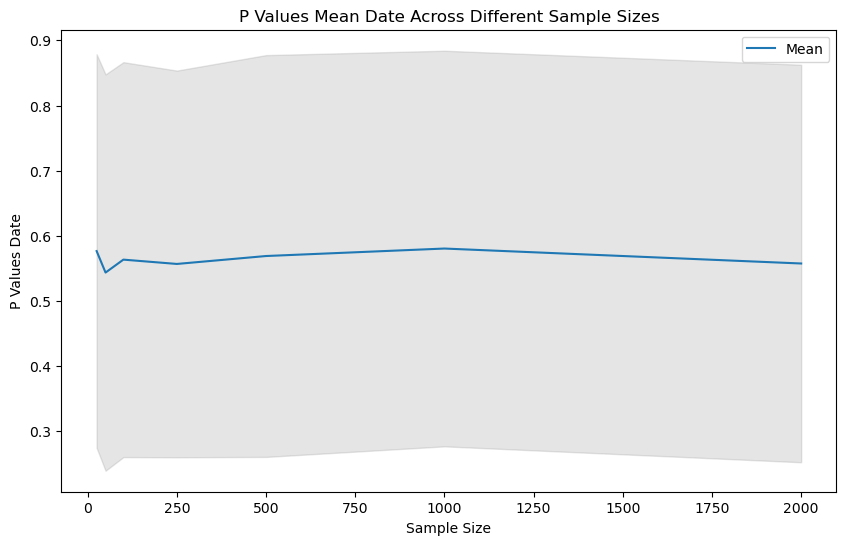

AttributeError: 'DataFrame' object has no attribute 'append'

In [19]:
import os
import numpy as np
import pandas as pd
import pickle  # Importing pickle for serialization
from scipy.stats import ks_2samp
from tqdm.auto import tqdm  # Using the tqdm.auto for universal progress bar compatibility
import matplotlib.pyplot as plt

# Function to load or generate bootstrap samples
def load_or_generate_bootstrap_samples(sample_size, num_iterations, full_data):
    """
    Load or generate bootstrap samples for a given sample size and number of iterations.

    Parameters:
    - sample_size (int): The size of each bootstrap sample.
    - num_iterations (int): The number of bootstrap samples to generate.
    - full_data (DataFrame): The original dataset to sample from.

    Returns:
    - List of DataFrames: A list containing the bootstrap samples.
    """

    # Directory and file paths for saving/loading samples
    directory = f'bootstrap-samples/statistics/k_s-date_range'
    file_path = os.path.join(directory, f'n_{sample_size}.pkl')

    # Ensure the directory exists
    os.makedirs(directory, exist_ok=True)

    # Try to load existing samples, otherwise generate new ones
    try:
        with open(file_path, 'rb') as f:
            bootstrap_samples = pickle.load(f)
        print(f"Loaded bootstrap samples from {file_path}")
    except FileNotFoundError:
        # Generating bootstrap samples with tqdm, added a description to the progress bar
        bootstrap_samples = [full_data.sample(n=sample_size, replace=True).copy().reset_index(drop=True) for _ in tqdm(range(num_iterations), desc=f"Generating bootstrap samples for n={sample_size}")]
        with open(file_path, 'wb') as f:
            pickle.dump(bootstrap_samples, f)
        print(f"Saved bootstrap samples to {file_path}")

    return bootstrap_samples

# Load the LIRE dataset into 'full_data'
full_data = lire

# Calculate the 'mean_date' for the full dataset
full_data['mean_date'] = (full_data['not_before'] + full_data['not_after']) / 2.0

# Define various sample sizes to test
sample_sizes = [25, 50, 100, 250, 500, 1000, 2000]

# Number of iterations for bootstrapping
num_iterations = 1000

# Dictionary to hold the K-S test results
ks_test_results = {}

# Initialize dictionaries to store standard errors and sample means
# This is done for both 'Date Range' and 'Mean Date' analyses.
standard_errors = {}
standard_errors_date = {}
sample_means = {}
sample_means_date = {}

# Loop over each sample size to perform K-S tests with tqdm progress bar and description
for sample_size in tqdm(sample_sizes, desc="Performing K-S tests across sample sizes"):
    bootstrap_samples = load_or_generate_bootstrap_samples(sample_size, num_iterations, full_data)

    # Lists to store D-statistics and P-values for 'date_range' and 'mean_date'
    d_statistics = []
    p_values = []
    d_statistics_date = []
    p_values_date = []

    # Run K-S test for each bootstrap sample
    for bootstrap_sample in tqdm(bootstrap_samples, desc=f'KS Test for n={sample_size}'):

        # Compute 'mean_date' for each bootstrap sample
        bootstrap_sample['mean_date'] = (bootstrap_sample['not_before'] + bootstrap_sample['not_after']) / 2.0

        # Perform K-S Test for 'date_range' and 'mean_date'
        d_stat, p_value = ks_2samp(full_data['date_range'], bootstrap_sample['date_range'])
        d_stat_date, p_value_date = ks_2samp(full_data['mean_date'], bootstrap_sample['mean_date'])

        # Append the results to the lists
        d_statistics.append(d_stat)
        p_values.append(p_value)
        d_statistics_date.append(d_stat_date)
        p_values_date.append(p_value_date)

    # Store the K-S test results in the dictionary
    ks_test_results[sample_size] = {'d_statistics': d_statistics, 'p_values': p_values,
                                    'd_statistics_date': d_statistics_date, 'p_values_date': p_values_date}

# Calculate means and standard deviations for each metric and sample size
means = {}
std_devs = {}

for metric in ['d_statistics', 'p_values', 'd_statistics_date', 'p_values_date']:
    means[metric] = []
    std_devs[metric] = []
    
    for sample_size in sample_sizes:
        means[metric].append(np.mean(ks_test_results[sample_size][metric]))
        std_devs[metric].append(np.std(ks_test_results[sample_size][metric]))

# Plot the K-S test results with trend lines and confidence intervals
for metric in ['d_statistics', 'p_values', 'd_statistics_date', 'p_values_date']:
    plt.figure(figsize=(10, 6))
    
    # Plot the trend line (mean)
    plt.plot(sample_sizes, means[metric], label='Mean')
    
    # Plot the confidence interval (mean ± std_dev)
    plt.fill_between(sample_sizes, np.array(means[metric]) - np.array(std_devs[metric]),
                     np.array(means[metric]) + np.array(std_devs[metric]), color='gray', alpha=0.2)
    
    plt.xlabel('Sample Size')
    plt.ylabel(metric.replace("_", " ").title())
    
    # Clarify titles to indicate what each plot represents
    if 'date' in metric:
        plt.title(f"{metric.replace('_', ' ').title().replace('Date', 'Mean Date')} Across Different Sample Sizes")
    else:
        plt.title(f"{metric.replace('_', ' ').title().replace('Statistics', 'Statistics for Date Range')} Across Different Sample Sizes")

    plt.legend()
    plt.show()


# Initialize an empty DataFrame to store the summary statistics
summary_stats = pd.DataFrame(columns=['Sample Size', 'Metric', 'Mean', 'Std Dev'])

# Loop through each metric and sample size to populate the DataFrame
for metric in ['d_statistics', 'p_values', 'd_statistics_date', 'p_values_date']:
    for sample_size in sample_sizes:
        mean_value = np.mean(ks_test_results[sample_size][metric])
        std_dev_value = np.std(ks_test_results[sample_size][metric])

        # Clarify the metric names to make them more descriptive
        if 'date' in metric:
            descriptive_metric = metric.replace('_', ' ').title().replace('Date', 'Mean Date')
        else:
            descriptive_metric = metric.replace('_', ' ').title().replace('Statistics', 'Statistics for Date Range')

        summary_stats = summary_stats.append({'Sample Size': sample_size, 'Metric': descriptive_metric, 
                                              'Mean': mean_value, 'Std Dev': std_dev_value}, ignore_index=True)

# Display the summary table
print("Summary Statistics for K-S Tests")
print("="*50)
print(summary_stats)

# Calculate standard errors and means for each metric and sample size.
# Standard error is calculated as the standard deviation divided by the square root of the sample size.
for sample_size in sample_sizes:
    standard_errors[sample_size] = np.std(ks_test_results[sample_size]['d_statistics']) / np.sqrt(sample_size)
    standard_errors_date[sample_size] = np.std(ks_test_results[sample_size]['d_statistics_date']) / np.sqrt(sample_size)
    
    sample_means[sample_size] = np.mean(ks_test_results[sample_size]['d_statistics'])
    sample_means_date[sample_size] = np.mean(ks_test_results[sample_size]['d_statistics_date'])

# Convert dictionaries to lists for ease of plotting
standard_errors_list = [standard_errors[s] for s in sample_sizes]
standard_errors_date_list = [standard_errors_date[s] for s in sample_sizes]
sample_means_list = [sample_means[s] for s in sample_sizes]
sample_means_date_list = [sample_means_date[s] for s in sample_sizes]

# Plot standard errors for each metric across various sample sizes
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, standard_errors_list, marker='o', label='Date Range')
plt.plot(sample_sizes, standard_errors_date_list, marker='x', label='Mean Date')
plt.xlabel('Sample Size')
plt.ylabel('Standard Error of the D-Statistic')
plt.title('Standard Error of the D-Statistic Across Different Sample Sizes')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the 95% confidence intervals for the mean D-statistics
lower_bound = np.array(sample_means_list) - 1.96 * np.array(standard_errors_list)
upper_bound = np.array(sample_means_list) + 1.96 * np.array(standard_errors_list)

lower_bound_date = np.array(sample_means_date_list) - 1.96 * np.array(standard_errors_date_list)
upper_bound_date = np.array(sample_means_date_list) + 1.96 * np.array(standard_errors_date_list)

# Plot the mean D-statistics with 95% confidence intervals for each metric across various sample sizes
plt.figure(figsize=(10, 6))
plt.errorbar(sample_sizes, sample_means_list, yerr=[sample_means_list - lower_bound, upper_bound - sample_means_list], fmt='o', label='D-Statistics for Date Range with 95% CI')
plt.errorbar(sample_sizes, sample_means_date_list, yerr=[sample_means_date_list - lower_bound_date, upper_bound_date - sample_means_date_list], fmt='x', label='D-Statistics for Mean Date with 95% CI')
plt.xlabel('Sample Size')
plt.ylabel('Mean D-Statistic')
plt.title('Mean D-Statistic with 95% Confidence Intervals Across Different Sample Sizes')
plt.legend()
plt.show()

# Display summary statistics for each sample size and metric, mimicking the format of your previous model
for sample_size in sample_sizes:
    print(f"\nFor a sample size of {sample_size}:")
    print(f"  Mean D-Statistic for Date Range: {sample_means[sample_size]}")
    print(f"  Standard Error of D-Statistic for Date Range: {standard_errors[sample_size]}")
    print(f"  Mean D-Statistic for Mean Date: {sample_means_date[sample_size]}")
    print(f"  Standard Error of D-Statistic for Mean Date: {standard_errors_date[sample_size]}")


### Standard Error (SE) of the date-range summed probability values

Using the same approach taken for means above

In [ ]:
# Assuming lire is your DataFrame
# lire = pd.read_csv("your_dataset.csv")

# Number of bootstrap iterations
n_iterations = 1000

# Sample sizes to investigate
sample_sizes = [25, 50, 100, 250, 500, 1000, 2000]

# Create 5-year bins for full dataset
bins = np.arange(lire['date_range'].min(), lire['date_range'].max() + 5, 5)
full_data_summed_prob = np.histogram(lire['date_range'], bins=bins, density=True)[0]

# Initialize a dictionary to hold results for each sample size
results = {}

# Initialize empty list to store standard error values for plotting
standard_errors = []

# Make sure the directory for saving the bootstrap samples exists
if not os.path.exists("bootstrap-samples/standard-error/summed-probabilities"):
    os.makedirs("bootstrap-samples/standard-error/summed-probabilities", exist_ok=True)

# Loop through each sample size
for sample_size in sample_sizes:

    # Create a dynamic file name
    saved_sample_path = f"bootstrap-samples/standard-error/summed-probabilities/n_{sample_size}.npy"
    
    if os.path.exists(saved_sample_path): # Check if saved bootstrap sample exists
        print("Loading saved bootstrap sample...")
        bootstrap_summed_probs = np.load(saved_sample_path, allow_pickle=True)
    else:
        # Initialize a list to hold the summed probabilities for each bootstrap sample
        bootstrap_summed_probs = []
    
        # Bootstrap sampling
        for i in range(n_iterations):
            # Sample with replacement from the dataset
            bootstrap_sample = lire['date_range'].sample(n=sample_size, replace=True)
            
            # Calculate the summed probability for this bootstrap sample
            bootstrap_summed_prob = np.histogram(bootstrap_sample, bins=bins, density=True)[0]
            
            # Store in the list
            bootstrap_summed_probs.append(bootstrap_summed_prob)

        # Save the sample
        print("Saving bootstrap sample...")
        np.save(saved_sample_path, bootstrap_summed_probs)

    # Convert to NumPy array for easier calculations
    bootstrap_summed_probs = np.array(bootstrap_summed_probs)
    
    # Calculate the standard error for each bin
    standard_errors_for_bins = np.std(bootstrap_summed_probs, axis=0)
    
    # Calculate the mean standard error for this sample size
    mean_standard_error = np.mean(standard_errors_for_bins)
    
    # Store the standard error for plotting
    standard_errors.append(mean_standard_error)
    
    # Store results in the dictionary
    results[sample_size] = {
        'standard_errors_for_bins': standard_errors_for_bins,
        'mean_standard_error': mean_standard_error,
        'bootstrap_summed_probs': bootstrap_summed_probs  # <-- Add this line
    }

# Display the results
for sample_size, metrics in results.items():
    print(f"\nFor a sample size of {sample_size}:")
    print(f"  Mean Standard Error for Summed Probabilities: {metrics['mean_standard_error']}")

# Plotting the standard errors
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, standard_errors, marker='o')
plt.xlabel('Sample Size')
plt.ylabel('Mean Standard Error of Summed Probability')
plt.title('Standard Error vs. Sample Size')
plt.grid(True)
plt.show()

# Plotting summed probabilities with 95% confidence intervals for each sample size
for sample_size, metrics in results.items():
    # Retrieve the bootstrap summed probabilities for this sample size
    bootstrap_summed_probs = metrics['bootstrap_summed_probs']
    
    # Calculate the mean summed probability across all bootstrap samples for this sample size
    mean_summed_prob = np.mean(bootstrap_summed_probs, axis=0) 
    
    # Calculate the 95% confidence intervals
    lower_bound = mean_summed_prob - 1.96 * metrics['standard_errors_for_bins']
    upper_bound = mean_summed_prob + 1.96 * metrics['standard_errors_for_bins']
    
    plt.figure(figsize=(10, 6))
    
    # Plot the mean summed probabilities
    plt.plot(bins[:-1], mean_summed_prob, marker='o', label='Mean Summed Probability')
    
    # Fill between the upper and lower confidence intervals
    plt.fill_between(bins[:-1], lower_bound, upper_bound, color='gray', alpha=0.5, label='95% CI')
    
    # Plot the summed probabilities for the full dataset for comparison
    plt.plot(bins[:-1], full_data_summed_prob, marker='x', linestyle='--', label='Full Dataset')
    
    plt.xlabel('Date Range')
    plt.xlim([0, 300])
    plt.ylabel('Summed Probability')
    plt.title(f'Summed Probability with 95% Confidence Intervals for Sample Size = {sample_size}')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Explanation of summed probability in this graph

The y-axis labeled "Summed Probability" represents the probability density of the data falling into each bin along the x-axis (in this case, each 5-year range). To clarify, it's not the probability of a single event occurring in that bin, but rather a density measure that gives you an idea of how many events fall into that time frame relative to the entire dataset.

In a histogram, if you just count the number of occurrences and plot them, you get a frequency distribution. If you divide each count by the total number of observations and further divide by the width of the bin, you get a probability density.

The "summed probability" term can be a bit misleading. In a probability density plot or histogram, the area under the curve sums to 1, but the individual y-values are density measures rather than probabilities in the usual sense.

So, if the y-value for a particular 5-year range is, say, 0.2, this doesn't mean there's a 20% chance of an event happening in that 5-year range. Rather, it means that the density of events in that 5-year range is 0.2 per year. To get the actual probability of an event happening within that 5-year bin, you would multiply this density by the width of the bin (in this case, 5 years).

# Summed Probability Analysis of entire dataset

## Various date-ranges and sample sizes; error based on date-range SD

In [ ]:

def compute_summed_probability(df, earliest_date, latest_date, resolution=5):
    """
    Compute the summed probability distribution of inscriptions with error margins.
    
    Parameters:
    - df: DataFrame containing the date ranges
    - earliest_date, latest_date: the date limits for the distribution
    - resolution: bin size for the histogram (in years)
    
    Returns:
    - summed_prob: summed probability distribution
    - std_devs: standard deviations for each bin
    """
    num_bins = int((latest_date - earliest_date) / resolution)
    summed_prob = np.zeros(num_bins)
    std_devs = np.zeros(num_bins)
    
    for _, row in df.iterrows():
        start_date = row['not_before']
        end_date = row['not_after']
        start_idx = int((start_date - earliest_date) / resolution)
        end_idx = int((end_date - earliest_date) / resolution)
        
        # Avoid negative or out-of-bounds indices
        start_idx = max(0, min(start_idx, num_bins - 1))
        end_idx = max(0, min(end_idx, num_bins - 1))
        
        # Calculate uniform probability for the given date range
        uniform_prob = 1.0 / (end_idx - start_idx + 1) if end_idx >= start_idx else 0
        
        # Distribute this uniform probability across the bins for the date range
        for i in range(start_idx, end_idx + 1):
            summed_prob[i] += uniform_prob
            std_devs[i] += (uniform_prob * (1 - uniform_prob))
            
    # Convert variances to standard deviations
    std_devs = np.sqrt(std_devs)
    
    return summed_prob, std_devs

# Filter your DataFrame to only include records with a date range <= thresholds

# Define date range thresholds for filtering; note that calculations are now *below* rather than *between* thresholds
thresholds = [(0, 0), (0, 10), (0, 25), (0, 50), (0, 100), (0, 200), (0, 300), (0, float('inf'))]

# Define overall earliest and latest date in the dataset, and bin resolution
earliest_date, latest_date = filtered_lire['not_before'].min(), filtered_lire['not_after'].max()
resolution = 5

# Define sample sizes to investigate
sample_sizes = [25, 50, 100, 250, 500, 1000, 2000]

# Add special value to signify using all records
sample_sizes.append('all')

# Loop through each date range threshold
for start, end in thresholds:
    
    # Filter DataFrame based on the current threshold
    if end == float('inf'):
        subset_df = filtered_lire[filtered_lire['date_range'] >= start]
        label = f"{start}+"
    elif start == 0 and end == 0:
        subset_df = filtered_lire[filtered_lire['date_range'] == 0]
        label = f"{start}"
    else:
        subset_df = filtered_lire[(filtered_lire['date_range'] >= start) & (filtered_lire['date_range'] <= end)]
        label = f"{start}-{end}"
    
    # Loop through each sample size
    for sample_size in sample_sizes:

         # Special case to use all records in filtered DataFrame
        if sample_size == 'all':
            subsample = filtered_lire
            size_label = "all"
        # Or, create a random subsample from the filtered DataFrame
        else:
            subsample = subset_df.sample(n=min(sample_size, len(subset_df)), random_state=42)
            size_label = str(sample_size)

        # Calculate the summed probability and standard deviations for the subsample
        summed_prob, std_devs = compute_summed_probability(subsample, earliest_date, latest_date, resolution=5)
        
        # Generate x-values for plotting, making sure they align in shape with summed_prob
        x_values = np.arange(earliest_date, latest_date, resolution)[:len(summed_prob)]
        
        plt.figure(figsize=(14, 7))
        
        # Plot the summed probability distribution
        plt.bar(x_values, summed_prob, width=resolution, color='blue', alpha=0.5, label='Summed Probability')
        
        # Calculate and plot the moving average
        window_size = 5
        moving_avg = np.convolve(summed_prob, np.ones(window_size)/window_size, mode='valid')
        
        # Calculate and plot the error margins
        moving_std_dev = np.convolve(std_devs, np.ones(window_size)/window_size, mode='valid')
        
        # Generate x-values for the moving average and error margins
        moving_avg_x = x_values[int(window_size/2):-int(window_size/2)+1][:len(moving_avg)]
        
        # Plot the moving average and fill between for the error margin
        plt.plot(moving_avg_x, moving_avg, color='red', label=f"{window_size}-bin Moving Average")
        plt.fill_between(moving_avg_x, moving_avg - moving_std_dev, moving_avg + moving_std_dev, color='red', alpha=0.2, label='Error Margin')
        
        plt.title(f"Summed Probability Distribution for Date Range {label}, Sample Size = {size_label}")
        plt.xlabel('Date')
        plt.xlim([-100, 600])
        plt.ylabel('Summed Probability')
        plt.legend()
        
        plt.show()


## Various date-ranges and sample sizes; bootstrapped confidence interval

In [ ]:
# Start summed probability function

def compute_summed_probability(df, earliest_date, latest_date, resolution=5):
    """
    Compute the summed probability distribution of inscriptions with error margins.
    
    Parameters:
    - df: DataFrame containing the date ranges
    - earliest_date, latest_date: the date limits for the distribution
    - resolution: bin size for the histogram (in years)
    
    Returns:
    - summed_prob: summed probability distribution
    - std_devs: standard deviations for each bin
    """
    num_bins = int((latest_date - earliest_date) / resolution)
    summed_prob = np.zeros(num_bins)
    std_devs = np.zeros(num_bins)
    
    for _, row in df.iterrows():
        start_date = row['not_before']
        end_date = row['not_after']
        start_idx = int((start_date - earliest_date) / resolution)
        end_idx = int((end_date - earliest_date) / resolution)
        
        # Avoid negative or out-of-bounds indices
        start_idx = max(0, min(start_idx, num_bins - 1))
        end_idx = max(0, min(end_idx, num_bins - 1))
        
        # Calculate uniform probability for the given date range
        uniform_prob = 1.0 / (end_idx - start_idx + 1) if end_idx >= start_idx else 0
        
        # Distribute this uniform probability across the bins for the date range
        for i in range(start_idx, end_idx + 1):
            summed_prob[i] += uniform_prob
            std_devs[i] += (uniform_prob * (1 - uniform_prob))
            
    # Convert variances to standard deviations
    std_devs = np.sqrt(std_devs)
    
    return summed_prob, std_devs

# End summed probability function

# Initialize parameters
n_iterations = 1000  # Number of bootstrap iterations
thresholds = [(0, 0), (0, 10), (0, 25), (0, 50), (0, 100), (0, 200), (0, 300), (0, float('inf'))]
earliest_date, latest_date = lire['not_before'].min(), lire['not_after'].max()
resolution = 5
sample_sizes = [25, 50, 100, 250, 500, 1000, 2000]
sample_sizes.append('all') # Add special value to signify using all records
window_size = 5 # Define the size of the moving window for the moving average

# Define directory to store bootstrap samples and create it if it doesn't exist
bootstrap_samples_dir = "bootstrap-samples/spa-ci/date-ranges/subsamples"
os.makedirs(bootstrap_samples_dir, exist_ok=True)

# Loop through each date range threshold
for start, end in thresholds:
    # Filter DataFrame based on the current threshold
    if end == float('inf'):
        subset_df = lire[lire['date_range'] >= start]
        label = f"{start}+"
    elif start == 0 and end == 0:
        subset_df = lire[lire['date_range'] == 0]
        label = f"{start}"
    else:
        subset_df = lire[(lire['date_range'] >= start) & (lire['date_range'] <= end)]
        label = f"{start}-{end}"
    # Save the number of inscriptions to a variable
    n_inscriptions = subset_df.shape[0]

    # Loop through each sample size
    for sample_size in sample_sizes:
        # Check for special case of sample_size = 'all'
        if sample_size == 'all':
            subsample = subset_df
            size_label = "all"
        # Or, create a random subsample from the filtered DataFrame
        else:
            subsample = subset_df.sample(n=min(sample_size, len(subset_df)), random_state=42)
            size_label = str(sample_size)
        # Generate filename for the bootstrap sample
        print(f"Checking for bootstrap sample file for date-range: {label}, sample size: {size_label}...") # Status message
        filename_info = f"date-range_{label}_sample-size_{size_label}"
        filename_hash = hashlib.md5(filename_info.encode()).hexdigest()
        saved_sample_path = os.path.join(bootstrap_samples_dir, f"{filename_hash}.npy")

        # Check if bootstrap sample file already exists
        if os.path.exists(saved_sample_path):
            print(f"Loading bootstrap sample file for date-range: {label}, sample size: {size_label}...") # Status message
            bootstrap_summed_probs = np.load(saved_sample_path)
        # If no bootstrap sample file exists, generate bootstrap sample and save it
        else:
            print(f"Calculating bootstrap samples for date-range: {label}, sample size: {size_label}...") # Status message
            bootstrap_summed_probs = np.zeros((n_iterations, int((latest_date - earliest_date) / resolution)))# Bootstrap sampling  <-- New block
            for i in tqdm(range(n_iterations)):  # Loop wrapped with tqdm to display a progress bar
                bootstrap_sample = subsample.sample(n=len(subsample), replace=True)
                bootstrap_summed_prob, _ = compute_summed_probability(bootstrap_sample, earliest_date, latest_date, resolution)
                bootstrap_summed_probs[i, :] = bootstrap_summed_prob
            
            # Save the computed bootstrap samples
            print(f"Saving bootstrap sample file for date-range: {label}, sample size: {size_label}...") # Status message
            np.save(saved_sample_path, bootstrap_summed_probs)

        # Calculate 95% confidence intervals
        lower_bound = np.percentile(bootstrap_summed_probs, 2.5, axis=0)
        upper_bound = np.percentile(bootstrap_summed_probs, 97.5, axis=0)

        # Calculate the summed probability and standard deviations for the subset
        summed_prob, _ = compute_summed_probability(subsample, earliest_date, latest_date, resolution)

        # Generate x-values for plotting
        x_values = np.arange(earliest_date, latest_date, resolution)[:len(summed_prob)]
    
        # Calculate moving average for summed_prob
        moving_avg = uniform_filter1d(summed_prob, size=window_size, mode='nearest')

        # Calculate moving average for the lower and upper bounds of the 95% CI
        moving_avg_lower = uniform_filter1d(lower_bound, size=window_size, mode='nearest')
        moving_avg_upper = uniform_filter1d(upper_bound, size=window_size, mode='nearest')

        # Plot the summed probability distribution
        plt.bar(x_values, summed_prob, width=resolution, color='blue', alpha=0.5, label='Summed Probability')
        
        # Plot the 95% confidence intervals  <-- New line
        plt.fill_between(x_values, lower_bound, upper_bound, color='gray', alpha=0.5, label='95% CI')
        
        # Plot the moving averages
        plt.plot(x_values, moving_avg, color='red', linestyle='-', linewidth=2, label='5-point MA (True)')

        # Add fill_between for the moving averages of the 95% CI
        plt.fill_between(x_values, moving_avg_lower, moving_avg_upper, color='orange', alpha=0.4, label='5-point MA (95% CI)')

        # Plot title; include number of inscriptions if subsample = 'all'
        if size_label == "all":
            plt.title(f"Summed Probability Distribution for Date Range {label}, all records (n={n_inscriptions})")
        else:
            plt.title(f"Summed Probability Distribution for Date Range {label}, Sample Size {size_label}")

        plt.xlabel('Date')
        plt.xlim([-100, 600])
        plt.ylabel('Summed Probability')
        plt.legend()
        
        plt.show()

## Reflections

The output of the SPA appears, at first glance, plausible as a proxy for either the population of the Latin-speaking regions of the Roman Empire, or perhaps the broader sociopolitical complexity, between about AD 1 - 400. Is so, it would indicate a high and slowly growing population (with some ups and downs) between ca. 1 - 200 AD, then a major downturn during the 'Crisis of the 3rd Century', followed by a partial rebound in the late 3rd and early 4th centuries AD, concluding with decline betwwen about the second quarter and the end of the 4th century. 

I now need to:

* compare this pattern with population estimates from Hansen and others
* refresh my lit review from 2020, looking especially to see if anyone has done SPA on inscriptions since then (I could find no indication of this approach at that time)
* apply this approach to subsets of the data: provinces, cities, etc., and see what those patterns look like



# SPA on major subsets of LIRE dataset

Use code from above, except:

1. Remove the sample_sizes loop and list to eliminate subsampling.
2. Exclude entries from the province of Roma by filtering out such rows from lire dataframe.
3. Update the folder path to save/load the bootstrap samples

No need for subsamples, that was exploratory. Will, however, still generate SPA for various date-ranges.

Changes in the code were so slight that I've attempted to run the three variations as part of one code block.

In [ ]:
# Start summed probability function

def compute_summed_probability(df, earliest_date, latest_date, resolution=5):
    """
    Compute the summed probability distribution of inscriptions with error margins.
    
    Parameters:
    - df: DataFrame containing the date ranges
    - earliest_date, latest_date: the date limits for the distribution
    - resolution: bin size for the histogram (in years)
    
    Returns:
    - summed_prob: summed probability distribution
    - std_devs: standard deviations for each bin
    """
    num_bins = int((latest_date - earliest_date) / resolution)
    summed_prob = np.zeros(num_bins)
    std_devs = np.zeros(num_bins)
    
    for _, row in df.iterrows():
        start_date = row['not_before']
        end_date = row['not_after']
        start_idx = int((start_date - earliest_date) / resolution)
        end_idx = int((end_date - earliest_date) / resolution)
        
        # Avoid negative or out-of-bounds indices
        start_idx = max(0, min(start_idx, num_bins - 1))
        end_idx = max(0, min(end_idx, num_bins - 1))
        
        # Calculate uniform probability for the given date range
        uniform_prob = 1.0 / (end_idx - start_idx + 1) if end_idx >= start_idx else 0
        
        # Distribute this uniform probability across the bins for the date range
        for i in range(start_idx, end_idx + 1):
            summed_prob[i] += uniform_prob
            std_devs[i] += (uniform_prob * (1 - uniform_prob))
            
    # Convert variances to standard deviations
    std_devs = np.sqrt(std_devs)
    
    return summed_prob, std_devs

# End summed probability function

# Function to run the analysis

def run_analysis(lire, bootstrap_samples_dir, file_prefix):
        
    # Constants
    X_LIM_LOW = -100
    X_LIM_HIGH = 600
    
    # Initialize parameters
    n_iterations = 1000  # Number of bootstrap iterations
    thresholds = [(0, 0), (0, 10), (0, 25), (0, 50), (0, 100), (0, 200), (0, 300), (0, float('inf'))]
    earliest_date, latest_date = lire['not_before'].min(), lire['not_after'].max()
    resolution = 5
    window_size = 5 # Define the size of the moving window for the moving average
    
    # Creat new bootstrap samples directory if it doesn't exist (parameter passed to this function)
    os.makedirs(bootstrap_samples_dir, exist_ok=True)
    
    # Loop through each date range threshold
    for start, end in thresholds:
        # Filter DataFrame based on the current threshold
        if end == float('inf'):
            subset_df = lire[lire['date_range'] >= start]
            label = f"{start}+"
        elif start == 0 and end == 0:
            subset_df = lire[lire['date_range'] == 0]
            label = f"{start}"
        else:
            subset_df = lire[(lire['date_range'] >= start) & (lire['date_range'] <= end)]
            label = f"{start}-{end}"
    
        # Save the number of inscriptions to a variable
        n_inscriptions = subset_df.shape[0]
    
        # Generate filename for the bootstrap sample
        print(f"Checking for bootstrap sample file for: date-range {label} {file_prefix}...")  # Status message
        filename_info = f"{file_prefix}-{label}" 
        filename_hash = hashlib.md5(filename_info.encode()).hexdigest()
        saved_sample_path = os.path.join(bootstrap_samples_dir, f"{filename_hash}.npy")
    
        # Check if bootstrap sample file already exists
        if os.path.exists(saved_sample_path):
            print(f"Loading bootstrap sample file for: date-range {label} {file_prefix}...") # Status message
            bootstrap_summed_probs = np.load(saved_sample_path)
        
        # If no bootstrap sample file exists, generate bootstrap sample and save it
        else:
            print(f"Calculating bootstrap samples for: date-range {label} {file_prefix}...") # Status message
            bootstrap_summed_probs = np.zeros((n_iterations, int((latest_date - earliest_date) / resolution)))# Bootstrap sampling  <-- New block
            for i in tqdm(range(n_iterations)):  # Loop wrapped with tqdm to display a progress bar
                bootstrap_sample = subset_df.sample(n=len(subset_df), replace=True)
                bootstrap_summed_prob, _ = compute_summed_probability(bootstrap_sample, earliest_date, latest_date, resolution)
                bootstrap_summed_probs[i, :] = bootstrap_summed_prob
               
            # Save the computed bootstrap samples
            print(f"Saving bootstrap sample file for: date-range {label} {file_prefix}...") # Status message
            np.save(saved_sample_path, bootstrap_summed_probs)
            
        # Calculate 95% confidence intervals
        lower_bound = np.percentile(bootstrap_summed_probs, 2.5, axis=0)
        upper_bound = np.percentile(bootstrap_summed_probs, 97.5, axis=0)
        
        # Calculate the summed probability and standard deviations for the subset
        summed_prob, _ = compute_summed_probability(subset_df, earliest_date, latest_date, resolution)
        
        # Generate x-values for plotting
        x_values = np.arange(earliest_date, latest_date, resolution)[:len(summed_prob)]
    
        
        # Calculate moving average for summed_prob
        moving_avg = uniform_filter1d(summed_prob, size=window_size, mode='nearest')
        
        # Calculate moving average for the lower and upper bounds of the 95% CI
        moving_avg_lower = uniform_filter1d(lower_bound, size=window_size, mode='nearest')
        moving_avg_upper = uniform_filter1d(upper_bound, size=window_size, mode='nearest')
        
        # Plot the summed probability distribution
        plt.bar(x_values, summed_prob, width=resolution, color='blue', alpha=0.5, label='Summed Probability')
    
        # Plot the 95% confidence intervals  <-- New line
        plt.fill_between(x_values, lower_bound, upper_bound, color='gray', alpha=0.5, label='95% CI')
    
        # Plot the moving averages
        plt.plot(x_values, moving_avg, color='red', linestyle='-', linewidth=2, label='5-point MA (True)')
        # Add fill_between for the moving averages of the 95% CI
        plt.fill_between(x_values, moving_avg_lower, moving_avg_upper, color='orange', alpha=0.4, label='5-point MA (95% CI)')
            
        plt.title(f"Summed Probability Distribution for Date Range {label} (n={n_inscriptions})")
        plt.xlabel('Date')
        plt.xlim([X_LIM_LOW, X_LIM_HIGH])
        plt.ylabel('Summed Probability')
        plt.legend()
    
        plt.show()

# End function to run the analysis

## Entire dataset excluding Roma

In [ ]:
# Run the analysis three times with different settings

# (1) for all provinces excluding Roma
print("Running analysis for all provinces excluding Roma...")
bootstrap_samples_dir_1 = "bootstrap-samples/spa-ci/date-ranges/no-roma"
file_prefix_1 = "no-roma"
lire_1 = lire[lire['province'] != 'Roma']
run_analysis(lire_1, bootstrap_samples_dir_1, file_prefix_1)


## Latin-speaking provinces only (including Roma)

In [ ]:
# (2) for only Latin-speaking provinces including Roma
print("Running analysis for Latin-speaking provinces including Roma...")
bootstrap_samples_dir_2 = "bootstrap-samples/spa-ci/date-ranges/latin-speaking"
file_prefix_2 = "latin-speaking"
lire_2 = lire[lire['province_language'] == 'Latin']
run_analysis(lire_2, bootstrap_samples_dir_2, file_prefix_2)

## Latin-speaking provinces only (excluding Roma)

In [ ]:
# (3) for only Latin-speaking provinces excluding Roma
print("Running analysis for Latin-speaking provinces excluding Roma...")
bootstrap_samples_dir_3 = "bootstrap-samples/spa-ci/date-ranges/latin-speaking-no-roma"
file_prefix_3 = "latin-speaking-no-roma"
lire_3 = lire[(lire['province'] != 'Roma') & (lire['province_language'] == 'Latin')]
run_analysis(lire_3, bootstrap_samples_dir_3, file_prefix_3)

# SPA of inscriptions from individual provinces

## List all the provinces in the LIRE dataset, with number of inscriptions

In [ ]:
# Count the unique values in the 'province' column
province_counts = lire['province'].value_counts()

# Exclude the 'none' entries if applicable
province_counts = province_counts[province_counts.index != 'none']

# Filter out provinces with fewer than 100 inscriptions
province_counts_filtered = province_counts[province_counts >= 100]

# Print inscription counts by province
print("Count of inscriptions by province (n>=100):")
print(province_counts_filtered)

## SPA on all provinces with at least 100 inscriptions

In [ ]:
# Start summed probability function

def compute_summed_probability(df, earliest_date, latest_date, resolution=5):
    """
    Compute the summed probability distribution of inscriptions with error margins.
    
    Parameters:
    - df: DataFrame containing the date ranges
    - earliest_date, latest_date: the date limits for the distribution
    - resolution: bin size for the histogram (in years)
    
    Returns:
    - summed_prob: summed probability distribution
    - std_devs: standard deviations for each bin
    """
    num_bins = int((latest_date - earliest_date) / resolution)
    summed_prob = np.zeros(num_bins)
    std_devs = np.zeros(num_bins)
    
    for _, row in df.iterrows():
        start_date = row['not_before']
        end_date = row['not_after']
        start_idx = int((start_date - earliest_date) / resolution)
        end_idx = int((end_date - earliest_date) / resolution)
        
        # Avoid negative or out-of-bounds indices
        start_idx = max(0, min(start_idx, num_bins - 1))
        end_idx = max(0, min(end_idx, num_bins - 1))
        
        # Calculate uniform probability for the given date range
        uniform_prob = 1.0 / (end_idx - start_idx + 1) if end_idx >= start_idx else 0
        
        # Distribute this uniform probability across the bins for the date range
        for i in range(start_idx, end_idx + 1):
            summed_prob[i] += uniform_prob
            std_devs[i] += (uniform_prob * (1 - uniform_prob))
            
    # Convert variances to standard deviations
    std_devs = np.sqrt(std_devs)
    
    return summed_prob, std_devs

# End summed probability function


# Function to clean automatically generated filenames

def clean_filename(filename):
    return re.sub(r'[^a-zA-Z0-9_]', '_', filename)

# End function

# Count the number of inscriptions for each unique province
province_counts = lire['province'].value_counts()

# Filter to only include provinces with at least 100 inscriptions
filtered_provinces = province_counts[province_counts >= 100].index.tolist()

# Initialize parameters for SPA
n_iterations = 1000  # Number of bootstrap iterations
earliest_date, latest_date = lire['not_before'].min(), lire['not_after'].max()
resolution = 5
window_size = 5 # Size of the moving window for the moving average

# Loop through each province
for province in filtered_provinces:
    # Create a dynamic file name for the province's bootstrap samples
    filename = clean_filename(province)
    saved_sample_path = f"bootstrap-samples/spa-ci/provinces/{filename}.npy"
    
    # Filter DataFrame based on the current province
    subset_df = lire[lire['province'] == province]

    # Get the number of inscriptions for this province
    n_inscriptions = len(subset_df)

    # Check if saved bootstrap samples exist for this province
    if os.path.exists(saved_sample_path):
        print(f"Loading saved bootstrap samples for {province}...")
        bootstrap_summed_probs = np.load(saved_sample_path)
        # print(f"Shape of loaded array: {bootstrap_summed_probs.shape}") # debug ValueError shape mismatch
    else:
        print(f"Performing bootstrap operation for {province}...")
        bootstrap_summed_probs = None
        for i in tqdm(range(n_iterations)):  # Loop wrapped with tqdm to display a progress bar
            bootstrap_sample = subset_df.sample(n=len(subset_df), replace=True)
            bootstrap_summed_prob, _ = compute_summed_probability(bootstrap_sample, earliest_date, latest_date, resolution)
            if bootstrap_summed_probs is None:
                bootstrap_summed_probs = np.zeros((n_iterations, len(bootstrap_summed_prob)))
            bootstrap_summed_probs[i, :] = bootstrap_summed_prob

        # debug_array = bootstrap_summed_probs # debug
        # print(f"Debug shape before saving: {debug_array.shape}") # debug ValueError shape mismatch
        # print(f"First element when generated: {debug_array[0]}") # debug ValueError shape mismatch
        print(f"Saving bootstrap samples for {province}...")
        np.save(saved_sample_path, bootstrap_summed_probs)
        # debug_array = np.load(saved_sample_path) # debug ValueError shape mismatch
        # print(f"Debug shape after saving: {debug_array.shape}") # debug ValueError shape mismatch
        # print(f"First element when loaded: {debug_array[0]}") # debug ValueError shape mismatch

    # Calculate 95% confidence intervals
    lower_bound = np.percentile(bootstrap_summed_probs, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_summed_probs, 97.5, axis=0)
    
    # Calculate the summed probability for the subset_df
    summed_prob, _ = compute_summed_probability(subset_df, earliest_date, latest_date, resolution)
    
    # Generate x-values for plotting
    x_values = np.arange(earliest_date, latest_date, resolution)[:len(summed_prob)]
    
    # Calculate moving average for summed_prob
    moving_avg = uniform_filter1d(summed_prob, size=window_size, mode='nearest')
    
    # Calculate moving average for the lower and upper bounds of the 95% CI
    moving_avg_lower = uniform_filter1d(lower_bound, size=window_size, mode='nearest')
    moving_avg_upper = uniform_filter1d(upper_bound, size=window_size, mode='nearest')
    
    plt.figure(figsize=(14, 7))
    plt.bar(x_values, summed_prob, width=resolution, color='blue', alpha=0.5, label='Summed Probability')
    plt.fill_between(x_values, lower_bound, upper_bound, color='gray', alpha=0.5, label='95% CI')
    plt.plot(x_values, moving_avg, color='red', linestyle='-', linewidth=2, label='5-point MA (True)')
    plt.fill_between(x_values, moving_avg_lower, moving_avg_upper, color='orange', alpha=0.4, label='5-point MA (95% CI)')
    
    plt.title(f"Summed Probability Distribution for Province: {province} (n={n_inscriptions})")
    plt.xlabel('Date')
    plt.xlim([-100, 600])
    plt.ylabel('Summed Probability')
    plt.legend()
    
    plt.show()


# SPA of inscriptions from individual named cities

### List all cities with at least 100 inscriptions

Here, we count the records for each unique value (city) in the column 'urban_context_city'

In [ ]:
# Count the unique values in the 'urban_context_city' column
city_counts = filtered_lire['urban_context_city'].value_counts()

# Exclude the 'none' entries
city_counts = city_counts[city_counts.index != 'none']

# Filter out cities with fewer than 100 inscriptions
city_counts_filtered = city_counts[city_counts >= 100]

# Print inscription counts by city
print("Count of inscriptions by city (with at least 100 inscriptions):")
print(city_counts_filtered)

## SPA on cities with at least 100 inscriptions

In [ ]:
# Start summed probability function

def compute_summed_probability(df, earliest_date, latest_date, resolution=5):
    """
    Compute the summed probability distribution of inscriptions with error margins.
    
    Parameters:
    - df: DataFrame containing the date ranges
    - earliest_date, latest_date: the date limits for the distribution
    - resolution: bin size for the histogram (in years)
    
    Returns:
    - summed_prob: summed probability distribution
    - std_devs: standard deviations for each bin
    """
    num_bins = int((latest_date - earliest_date) / resolution)
    summed_prob = np.zeros(num_bins)
    std_devs = np.zeros(num_bins)
    
    for _, row in df.iterrows():
        start_date = row['not_before']
        end_date = row['not_after']
        start_idx = int((start_date - earliest_date) / resolution)
        end_idx = int((end_date - earliest_date) / resolution)
        
        # Avoid negative or out-of-bounds indices
        start_idx = max(0, min(start_idx, num_bins - 1))
        end_idx = max(0, min(end_idx, num_bins - 1))
        
        # Calculate uniform probability for the given date range
        uniform_prob = 1.0 / (end_idx - start_idx + 1) if end_idx >= start_idx else 0
        
        # Distribute this uniform probability across the bins for the date range
        for i in range(start_idx, end_idx + 1):
            summed_prob[i] += uniform_prob
            std_devs[i] += (uniform_prob * (1 - uniform_prob))
            
    # Convert variances to standard deviations
    std_devs = np.sqrt(std_devs)
    
    return summed_prob, std_devs

# End summed probability function


# Function to clean automatically generated filenames

def clean_filename(filename):
    return re.sub(r'[^a-zA-Z0-9_]', '_', filename)

# End function


# Count the number of inscriptions of each unique city
city_counts = lire['urban_context_city'].value_counts()

# Filter the cities that have at least 100 inscriptions
filtered_cities = city_counts[city_counts >= 100].index.tolist()

# Optionally, print out the list and counts for verification
# print("Filtered cities and their respective counts:")
# print(city_counts[city_counts >= 240])

# Optionally, print the list of filtered cities
# print("List of filtered cities:")
# print(filtered_cities)

# Initialize parameters for SPA
n_iterations = 1000  # Number of bootstrap iterations
earliest_date, latest_date = lire['not_before'].min(), lire['not_after'].max()
resolution = 5
window_size = 5 # Size of the moving window for the moving average

# Loop through each city
for city in filtered_cities:
    # Create a dynamic file name for the city's bootstrap samples
    filename = clean_filename(city)
    saved_sample_path = f"bootstrap-samples/spa-ci/cities/{filename}.npy"

    
    # Filter DataFrame based on the current city
    subset_df = lire[lire['urban_context_city'] == city]

    # Get the number of inscriptions for this city
    n_inscriptions = len(subset_df)

    # Check if saved bootstrap samples exist for this province
    if os.path.exists(saved_sample_path):
        # Load saved bootstrap samples
        print(f"Loading saved bootstrap samples for {city}...")
        bootstrap_summed_probs = np.load(saved_sample_path)
    else:
        print(f"Performing bootstrap operation for {city}...")
        # Initialize storage for bootstrap results
        bootstrap_summed_probs = None
        # Bootstrap sampling
        for i in tqdm(range(n_iterations)):  # Loop wrapped with tqdm to display a progress bar
            bootstrap_sample = subset_df.sample(n=len(subset_df), replace=True)
            bootstrap_summed_prob, _ = compute_summed_probability(bootstrap_sample, earliest_date, latest_date, resolution)
            if bootstrap_summed_probs is None:
                bootstrap_summed_probs = np.zeros((n_iterations, len(bootstrap_summed_prob)))
            bootstrap_summed_probs[i, :] = bootstrap_summed_prob
        
        # Save the bootstrap samples
        print(f"Saving bootstrap samples for {city}...")
        np.save(saved_sample_path, bootstrap_summed_probs)
        
    # Calculate 95% confidence intervals
    lower_bound = np.percentile(bootstrap_summed_probs, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_summed_probs, 97.5, axis=0)
    
    # Calculate the summed probability for the subset_df
    summed_prob, _ = compute_summed_probability(subset_df, earliest_date, latest_date, resolution)
    
    # Generate x-values for plotting
    x_values = np.arange(earliest_date, latest_date, resolution)[:len(summed_prob)]
    
    # Calculate moving average for summed_prob
    moving_avg = uniform_filter1d(summed_prob, size=window_size, mode='nearest')
    
    # Calculate moving average for the lower and upper bounds of the 95% CI
    moving_avg_lower = uniform_filter1d(lower_bound, size=window_size, mode='nearest')
    moving_avg_upper = uniform_filter1d(upper_bound, size=window_size, mode='nearest')
    
    plt.figure(figsize=(14, 7))
    plt.bar(x_values, summed_prob, width=resolution, color='blue', alpha=0.5, label='Summed Probability')
    plt.fill_between(x_values, lower_bound, upper_bound, color='gray', alpha=0.5, label='95% CI')
    plt.plot(x_values, moving_avg, color='red', linestyle='-', linewidth=2, label='5-point MA (True)')
    plt.fill_between(x_values, moving_avg_lower, moving_avg_upper, color='orange', alpha=0.4, label='5-point MA (95% CI)')
    
    plt.title(f"Summed Probability Distribution for {city} (n={n_inscriptions})")
    plt.xlabel('Date')
    plt.xlim([-100, 600])
    plt.ylabel('Summed Probability')
    plt.legend()
    
    plt.show()


## Reflections

I need to:

* Rerun empire-wide statistics without Rome - DONE
* Eliminate non-Latin-speaking provinces - DONE
* Decide what inscriptions to include in analyses (<=200-year date range? 300 year? All?)
* Finalise sample-size cut-offs for analysing urban places (250 inscriptions? 500? 750?)
* Save bootstrapping data to files throughout so that it all runs faster - DONE
* Run on BinderHub
* Re-run Hanson's analysis comparing urban populations from other sources (his work, included in LIRE) to the number of inscriptions, with residuals for urban places
* Run Hanson's analysis amalgamating to the province level
* Run Hanson's anlysis amalgamating to the Latin-speaking-empire level
* Consider whether Hanson's analysis can be improved by looking at duration of occupation; it seems to me that he simply presents the (maximum?) size of the settlement, ignoring duration of occuption, which may complicate the relationship between the number of inscriptions and the population - longer-lived settlements will produce more inscriptions at the same population size. Maybe some sort of dirivative metric, like average number of inscriptions per year at the site.
* Using whatever coefficients of coreleation that produces, calculate changing population over time using SPA on inscriptions
* Extrapolate / amalgamate to province-level and (Latin speaking) empire-level
* Do plots showing changing contributions to overall population (itself changing) of cities --> provinces, provinces --> Latin-speaking empire.
* Do the analysis based on word count per location instead of inscription count

The overal point or hook is the ability not only to get a static (maximum?) urban place size (like Hanson has done), but to plot population over time using inscriptions as a proxy, where enough inscriptions exist, and do it all responsibly with appropriate confidence intervals and qualifications.

# Extending Hanson 2021

## Reproduce Hanson's correlation between inscription count and his independent population estimate

Hanson (2021, 143) briefly discusses SPA using inscriptions, although he references Wilson (2009) on shipwrecks rather than the extensive literature on radiocarbon dates. He then uses the SPA only to support the broad observation that most of the inscriptions date to the first and second century AD, and therefor correspond to the time when the population was greatest. Before moving on to a diachronic analysis that correlates the total number of inscriptions from each site to the maximum population of the site, he observes that 'using more refined date ranges would be an interesting matter for furture research'. This analysis takes up that challenge.

### Filter named 'urban_context_city' records and display them with population.

In [ ]:
# Filter the DataFrame to exclude rows where 'urban_context_city' is 'None'
# or where 'urban_context_pop_est' is NaN
filtered_df = lire[(lire['urban_context_city'] != 'None') & (lire['urban_context_pop_est'].notna())]

# Get unique cities that have a population estimate
unique_cities_with_pop = filtered_df[['urban_context_city', 'urban_context_pop_est']].drop_duplicates()

# Sort the DataFrame by population estimate in descending order
sorted_unique_cities = unique_cities_with_pop.sort_values(by='urban_context_pop_est', ascending=False)

# Display the first 10 records of the sorted DataFrame using to_string() for column spacing
print(sorted_unique_cities.head(10).to_string(index=False, col_space=12))

# Display the total number of unique cities with population estimates
total_records = sorted_unique_cities.shape[0]
print(f"Total number of unique cities with population estimates: {total_records}")

In [ ]:
### Create new df including city name, population estimate, and inscription count

In [ ]:
# Generate a list of unique cities that have population estimates
unique_cities_with_pop = lire[(lire['urban_context_city'] != 'None') & (lire['urban_context_pop_est'].notna())]['urban_context_city'].unique()

# Group by 'urban_context_city' and 'urban_context_pop_est', then count the number of inscriptions for each city
grouped_df = lire[(lire['urban_context_city'] != 'None') & (lire['urban_context_pop_est'].notna())].groupby(['urban_context_city', 'urban_context_pop_est']).size().reset_index(name='inscription_count')

# Sort the DataFrame by 'urban_context_pop_est' in descending order
grouped_df_sorted = grouped_df.sort_values(by='urban_context_pop_est', ascending=False)

# Display the DataFrame in a tight layout
print("\nTop 10 cities sorted by population estimate, along with their inscription counts:")
print(grouped_df_sorted.head(10).to_string(index=False, col_space=12))

# Display the total number of records in the grouped DataFrame
total_records_grouped = grouped_df_sorted.shape[0]
print(f"\nTotal number of records in the DataFrame: {total_records_grouped}")


#### Filter for Latin-speaking only, and exclude Roma

In [ ]:
# Filter to include only Latin-speaking provinces and exclude the city 'Roma'
latin_provinces_df = lire[(lire['province_language'] == 'Latin') & (lire['urban_context_city'] != 'Roma')]

# Generate a list of unique cities in Latin-speaking provinces that have population estimates
unique_cities_with_pop = latin_provinces_df[(latin_provinces_df['urban_context_city'] != 'None') & (latin_provinces_df['urban_context_pop_est'].notna())]['urban_context_city'].unique()

# Group by 'urban_context_city' and 'urban_context_pop_est', then count the number of inscriptions for each city
grouped_df = latin_provinces_df[(latin_provinces_df['urban_context_city'] != 'None') & (latin_provinces_df['urban_context_pop_est'].notna())].groupby(['urban_context_city', 'urban_context_pop_est']).size().reset_index(name='inscription_count')

# Sort the DataFrame by 'urban_context_pop_est' in descending order
grouped_df_sorted = grouped_df.sort_values(by='urban_context_pop_est', ascending=False)

# Display the DataFrame in a tight layout
print("\nTop 10 cities in Latin-speaking provinces sorted by population estimate, along with their inscription counts:")
print(grouped_df_sorted.head(10).to_string(index=False, col_space=12))

# Display the total number of records in the grouped DataFrame
total_records_grouped = grouped_df_sorted.shape[0]
print(f"\nTotal number of records in the DataFrame: {total_records_grouped}")

## Ordinary Least Squares (OLS) regression

### Reproducing Hanson's appraoch to determining a relationship between city poputlation and inscription count

In [ ]:
# Prepare data for OLS regression
# Note: statsmodels requires us to add a constant term for the intercept
X = grouped_df_sorted['urban_context_pop_est']  # Predictor variable (Population)
y = grouped_df_sorted['inscription_count']  # Response variable (Number of inscriptions)
X = sm.add_constant(X)  # Adding a constant for the intercept term

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print out the model statistics
print(model.summary())

# Generate predicted values and standard errors
predictions = model.predict(X)
pred_std = model.get_prediction(X).se_obs

# Calculate upper and lower 95% confidence intervals
ci_upper = predictions + 1.96 * pred_std
ci_lower = predictions - 1.96 * pred_std

# Plot the data and the OLS fit line along with confidence intervals
plt.scatter(X['urban_context_pop_est'], y, label='Data', alpha=0.5)
plt.xlabel('Population Estimate')
plt.ylabel('Inscription Count')
plt.title('OLS Fit with 95% Confidence Interval: Relationship between Population and Inscription Count')
plt.plot(X['urban_context_pop_est'], predictions, color='red', label='OLS Fit Line')
plt.fill_between(X['urban_context_pop_est'], ci_lower, ci_upper, color='gray', alpha=0.2, label='95% CI')
plt.legend()
plt.show()


Hypothesis: cities of higher population produce more inscriptions. Population is the predictor variable and inscriptions are the response variable.

### Interpreting OLS regression results: ChatGPT help

The \( R^2 \) value, also known as the coefficient of determination, is a measure of how well the model's predictions match the actual data. An \( R^2 \) value of 1 indicates that the model perfectly predicts the outcome variable, whereas a value of 0 indicates that the model is no better than a model that simply predicts the mean of the target variable for all observations.

In your case, an \( R^2 \) value of 0.039 suggests that only about 3.9% of the variability in the population estimate can be explained by the number of inscriptions. This is a very low value and indicates a weak relationship between the two variables, according to the model.

Here are some considerations for interpreting this \( R^2 \) value:

1. **Low Predictive Power:** The model has low predictive power for estimating population based on the number of inscriptions.
  
2. **Other Factors:** Given the low \( R^2 \), it's likely that other factors, not included in the model, have a significant impact on the population estimate.

3. **Linear Fit Might Not Be Appropriate:** The low \( R^2 \) could also mean that the relationship between the variables is not linear, and a linear model is not the best fit for the data.

4. **Data Quality:** Always consider the possibility that the data itself might have issues. For example, if the population estimates are not reliable or if the inscription counts are incomplete, that could affect the \( R^2 \) value.

So, while the \( R^2 \) value is a useful statistic, it's important to consider it in the context of your specific study, the quality of your data, and your understanding of the underlying processes that generate that data.

The F-statistic is a measure used to assess the significance of the overall regression model. It is used in the context of an F-test where it's compared to a critical value that depends on the degrees of freedom. A larger F-statistic indicates that the model is more likely to be statistically significant, i.e., at least one of the predictor variables in the regression model is statistically significant.

In your case, an F-statistic of 32.94 suggests that the regression model is statistically significant at conventional levels (usually \( p < 0.05 \)), meaning that there is evidence to reject the null hypothesis that all of the regression coefficients are equal to zero (i.e., that none of the predictors are useful).

However, it's essential to interpret the F-statistic in the context of the data and the subject-matter:

1. **Significance Doesn't Mean Effect Size:** While the F-statistic tells you whether or not the model as a whole is statistically significant, it doesn't tell you how strong the relationship is. For that, you'll have to look at measures like \( R^2 \).

2. **Data Quality:** As with \( R^2 \), the F-statistic can also be influenced by the quality of your data. If the data are noisy, incomplete, or biased, the F-statistic may be misleading.

3. **Multiple Predictors:** In models with multiple predictors, the F-statistic tests whether at least one predictor is useful for predicting the response variable. However, in your case, you have only one predictor, making the F-statistic and the t-test for the predictor's coefficient essentially provide the same information.

So, the F-statistic of 32.94 suggests that your model is statistically significant, but given the low \( R^2 \), the practical relevance of this finding might be limited. The model accounts for a very small proportion of the variance in the response variable, indicating a weak relationship despite statistical significance.

Certainly, let's discuss the table line by line.

#### Intercept (const)

The constant term (`const`) in the regression equation is the value of the dependent variable (the number of inscriptions in this case) when all independent variables are zero. Here, the `coef` (coefficient) value for `const` is 59.7384. This means that if a city had a population of zero (which is not practical in real-world terms), the model predicts that there would be approximately 59.7 inscriptions.

#### std err (10.787)
This represents the standard error of the coefficient estimate for the intercept. The smaller the standard error, the more precise the estimate. 

#### t (5.538)
This is the t-value, which is calculated by dividing the coefficient by its standard error. The higher the t-value, the stronger the evidence against the null hypothesis, which suggests no effect.

#### P>|t| (0.000)
This p-value being close to zero indicates that the intercept is statistically significant, meaning that the observed number of inscriptions when all independent variables are zero would not be due to random chance.

#### [0.025 0.975] (38.565 80.912)
These are the 95% confidence intervals for the intercept. The model is 95% confident that the true intercept value lies between 38.565 and 80.912.

#### Coefficient for urban_context_pop_est (0.0055)

The coefficient for `urban_context_pop_est` tells us about the size and direction of the relationship between population and the number of inscriptions. A coefficient of 0.0055 means that for each unit increase in population, the number of inscriptions is expected to increase by 0.0055 units.

#### std err (0.001)
The standard error of 0.001 indicates the accuracy of this coefficient.

#### t (5.739)
The t-value of 5.739 is high, further supporting the rejection of the null hypothesis that this variable has no effect.

#### P>|t| (0.000)
The p-value being close to zero suggests that this relationship is statistically significant.

#### [0.025 0.975] (0.004 0.007)
The 95% confidence interval indicates that we are 95% confident that the true coefficient value lies between 0.004 and 0.007.

In summary, the model is statistically significant, and both the intercept and the population variable appear to have a statistically significant relationship with the number of inscriptions. However, as discussed earlier, the R-squared value suggests that population alone does not explain much of the variance in the number of inscriptions.

## Considering alternative approaches

Certainly! Here's an expanded explanation for each approach:

### Count Data Models
1. **Poisson Regression**: This approach is useful for count data like the number of inscriptions. It assumes that the mean and variance of the distribution are equal. This is a common starting point for analyzing count data but can be too restrictive if the data is overdispersed.
   
2. **Negative Binomial Regression**: This is an extension of Poisson regression that introduces an extra parameter to account for overdispersion—when the data exhibits more variability than what the Poisson model can handle.

### Linear Models & Extensions
3. **Generalized Linear Models (GLM)**: GLMs are a flexible generalization of ordinary linear models, allowing for response variables that have error distribution models other than a normal distribution. The link function specifies the relationship between the linear predictor and the mean of the response variable.
   
4. **Robust Regression**: This technique is similar to OLS but less sensitive to outliers and high-leverage points. It modifies the loss function to be more forgiving of such data points.
   
5. **Ridge and Lasso Regression**: These are linear models with a twist. They include a penalty term on the coefficients to prevent them from getting too large, essentially regularizing the model to prevent overfitting.
  
6. **Polynomial Regression**: This technique fits a nonlinear equation to the data but does it within the framework of linear regression. It's useful when the relationship between variables is clearly not linear.
   
7. **Mixed-Effects Models**: Useful when there's a grouping variable (e.g., province, time period) that could introduce correlations between observations. This model accounts for both fixed and random effects.

### Machine Learning Models
8. **Random Forests**: This ensemble method uses multiple decision trees during training and outputs the average prediction of the individual trees for regression problems. It's good for capturing complex relationships but sacrifices some interpretability.

9. **Gradient Boosting**: Another ensemble technique that builds trees one at a time, where each one corrects the errors of its predecessor. Like Random Forests, it can model complex relationships but can be harder to interpret.

### Bayesian Methods
10. **Bayesian Linear Regression**: This approach offers a probabilistic framework that goes beyond point estimates to provide a full distribution for the model's parameters. This accounts for uncertainty and can produce more robust results.
  
### Non-parametric Models
11. **Spearman's Rank Correlation**: This is a non-parametric test that assesses the strength and direction of the relationship between two variables without making any assumptions about the relationship's form.

12. **Kernel Regression**: This is a more flexible non-parametric technique that does not assume a specific functional form of the relationship between variables.

### Miscellaneous
13. **Bootstrapping**: This resampling technique is useful for small datasets or when the underlying distribution is unknown. It can provide more robust estimates by repeatedly sampling with replacement from the data.
  
14. **Log-Transformation**: If the variables span several orders of magnitude or if the relationship seems multiplicative, applying a log transformation can linearize the relationship, making it easier to model.

Would you like to proceed with any of these methods?

## Log transformation of OSL regression

In [ ]:
# Log-transform the variables
grouped_df_sorted['log_urban_context_pop_est'] = np.log1p(grouped_df_sorted['urban_context_pop_est'])
grouped_df_sorted['log_inscription_count'] = np.log1p(grouped_df_sorted['inscription_count'])

# Prepare data for OLS regression after log-transformation
X_log = grouped_df_sorted['log_urban_context_pop_est']  # Log-transformed predictor variable
y_log = grouped_df_sorted['log_inscription_count']  # Log-transformed response variable
X_log = sm.add_constant(X_log)  # Adding a constant for the intercept term

# Fit the OLS model on log-transformed data
model_log = sm.OLS(y_log, X_log).fit()

# Print out the model statistics
print(model_log.summary())

# Get prediction standard errors for 95% confidence interval
_, iv_l, iv_u = wls_prediction_std(model_log)

# Plot the data and the OLS fit line for log-transformed data
plt.scatter(X_log['log_urban_context_pop_est'], y_log, label='Log-Transformed Data', alpha=0.7)
plt.xlabel('Log(Population Estimate)')
plt.ylabel('Log(Inscription Count)')
plt.title('OLS Fit on Log-Transformed Data with 95% Confidence Interval')

# Plot OLS fit line
plt.plot(X_log['log_urban_context_pop_est'], model_log.predict(X_log), color='red', label='OLS Fit Line')

# Plot 95% confidence interval
plt.fill_between(X_log['log_urban_context_pop_est'], iv_l, iv_u, color='gray', alpha=0.3, label='95% Conf. Int.')

plt.legend()
plt.show()


## Interpretation of log-transformed OLS results - ChatGPT

Certainly! Let's walk through the output of the log-transformed OLS regression model.

### General Information

- **Dep. Variable**: This is the dependent (response) variable, which is `log_inscription_count` after log-transformation.
- **R-squared**: This statistic indicates the proportion of the variance for the dependent variable that's explained by the independent variable. In this case, the R-squared value of 0.101 indicates that approximately 10.1% of the variation in log-transformed inscription count is explained by the log-transformed population estimate.
- **Adj. R-squared**: Similar to R-squared but adjusted for the number of predictors. Since we have only one predictor, this value is almost the same as R-squared.
- **F-statistic**: The F-statistic tests whether at least one predictor variable has a non-zero coefficient. An F-statistic of 91.56 is quite high, indicating that the model is likely a good fit.
- **Prob (F-statistic)**: This is the probability of observing a test statistic as extreme as the one for your model if the null hypothesis is true. A value close to zero means the model is statistically significant.
- **Log-Likelihood**: The log of the likelihood function for the estimated model. Generally, higher values are better, though this metric is mostly useful for comparing different models fitted to the same dataset.
- **AIC and BIC**: These are the Akaike and Bayesian Information Criteria, respectively. These metrics offer a balance between goodness-of-fit and model complexity, with lower values generally indicating better models.

### Coefficients Table

- **coef**: These are the estimated coefficients. For `log_urban_context_pop_est`, it's 0.4725, meaning that for each unit increase in log-transformed population estimate, we expect an increase of 0.4725 in log-transformed inscription count.
- **std err**: This is the standard error of the coefficient estimate, useful for hypothesis tests and for constructing confidence intervals.
- **t**: This is the t-statistic, calculated by dividing the coefficient by its standard error. Higher absolute values generally indicate greater significance.
- **P>|t|**: The p-value associated with the t-statistic. A p-value close to zero indicates that the predictor is a significant predictor of the outcome variable.
- **[0.025, 0.975]**: These are the 95% confidence intervals for the coefficient. Since this interval does not contain zero for `log_urban_context_pop_est`, it's a sign that this variable is a significant predictor.

### Additional Diagnostics

- **Omnibus, Durbin-Watson, Jarque-Bera (JB), Skew, Kurtosis, and Cond. No.**: These are additional tests and metrics that assess the residuals and other model assumptions. They are generally more important when diagnosing issues with the regression model.

Based on these results, the log-transformed model seems to provide a better fit compared to the original model, but still, only around 10.1% of the variation in inscription count is explained by population size. The model is statistically significant, and the coefficient for log-transformed population size is also statistically significant.

I hope that helps clarify the output! Would you like to move on to trying out some other modeling techniques?

Certainly! This table provides detailed statistics for each coefficient (constant and predictor) in the model. Let's look at each row in detail:

### Constant (Intercept)
- **coef = -0.5180**: This is the y-intercept of the regression line in the log-transformed space. It represents the expected value of the log-transformed inscription count when the log-transformed population estimate is zero. Given that both variables are log-transformed, the interpretation is not as straightforward as in a simple linear regression.
  
- **std err = 0.391**: This is the standard error of the coefficient. It gives an idea of the uncertainty around the estimate of the intercept.

- **t = -1.326**: This is the t-statistic for the hypothesis test that checks whether this coefficient is different from zero. A t-value far from zero indicates that the coefficient is statistically significant, but here the value is relatively close to zero.

- **P>|t| = 0.185**: This is the p-value for the test of the null hypothesis that this coefficient is zero. A value greater than 0.05 usually suggests that the coefficient is not statistically significant.

- **[0.025, 0.975] = [-1.285, 0.249]**: This is the 95% confidence interval for the coefficient. Since this interval contains zero, it's another sign that the constant is not statistically significant.

### log_urban_context_pop_est (Predictor)
- **coef = 0.4725**: This is the slope of the regression line in the log-transformed space. It means that for a one-unit increase in the log-transformed population, we expect a 0.4725-unit increase in the log-transformed inscription count.

- **std err = 0.049**: This is the standard error of the coefficient. Smaller values indicate more precise estimates.

- **t = 9.568**: This t-statistic is far from zero, suggesting that the predictor is statistically significant.

- **P>|t| = 0.000**: A p-value close to zero confirms that this predictor is statistically significant.

- **[0.025, 0.975] = [0.376, 0.569]**: This is the 95% confidence interval for the predictor coefficient. Since it does not contain zero, we can say with 95% confidence that an increase in log-transformed population is associated with an increase in log-transformed inscription count.

I hope this detailed walk-through clarifies each part of the table! Would you like to proceed with the other modeling techniques now?

The statistical significance of the constant (intercept) and predictor variables in a regression model have different implications:

### Constant (Intercept) Not Statistically Significant
- **What it means**: The intercept being not statistically significant means that when the predictor variable is zero (in this case, when the log-transformed population is zero), we can't confidently say that the log-transformed inscription count would differ from zero. Given that both variables are log-transformed, this isn't a straightforward interpretation as it would be in a simple linear regression.
  
- **Implications**: In most practical situations, especially in this case where both variables are log-transformed, the intercept being non-significant isn't typically a concern. You're generally more interested in the relationship between the variables, not the absolute value of the output when the input is zero. 

### Predictor Statistically Significant
- **What it means**: This is usually what you are most interested in. A statistically significant predictor suggests there's evidence to reject the null hypothesis that the predictor has no effect on the outcome variable. In other words, there's a relationship between the population and inscription count, at least in the dataset you're working with.

- **Implications**: Since the predictor is significant, the focus will often be on understanding this relationship further, possibly by considering more complex models, adding additional predictors, or investigating causality (which regression alone cannot establish).

### Summary
In a nutshell, the constant's lack of significance is usually not a major issue if you are interested in the relationship between variables, especially in cases like this where both the predictor and the response are log-transformed. The statistical significance of the predictor variable is more critical for your analysis, as it suggests that there's a relationship between city population and inscription count that is worth investigating further.

## How disperesed is my data?

Choice of regression model partly depends upon how dispersed the data is - here we run a check for dispersal, comparing mean inscription count to the variance of inscription count. If the latter is much higher, the data is 'dispersed'.

In [ ]:
# Calculate the mean and variance of the inscription count
mean_inscription_count = grouped_df_sorted['inscription_count'].mean()
var_inscription_count = grouped_df_sorted['inscription_count'].var()

print(f"Mean of Inscription Count: {mean_inscription_count}")
print(f"Variance of Inscription Count: {var_inscription_count}")


Yeah, that's a high ratio, data is definitely 'dispersed'. Let's use a Negative Binomial Regression

## Negative Binomial Regression

In [ ]:
# Prepare the data and fit the Negative Binomial model (as before)
X = grouped_df_sorted['log_urban_context_pop_est']
y = grouped_df_sorted['inscription_count']
X = sm.add_constant(X)
model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

# Generate predictions and calculate the confidence interval for new observations
predictions = model.get_prediction(X)
frame = predictions.summary_frame(alpha=0.05)

print(model.summary())

# Plot the observed data
plt.scatter(X['log_urban_context_pop_est'], y, label='Observed', alpha=0.7)

# Plot the fitted values
plt.plot(X['log_urban_context_pop_est'], frame['mean'], label='Fitted', color='red')

# Plot the 95% confidence intervals
plt.fill_between(X['log_urban_context_pop_est'], frame['mean_ci_lower'], frame['mean_ci_upper'], color='red', alpha=0.3, label='95% CI')

# Customize the plot
plt.xlabel('Log of Population Estimate')
plt.ylabel('Inscription Count')
plt.title('Negative Binomial Regression Fit')
plt.legend()

# Show the plot
plt.show()

## Interpretation from ChatGPT

Certainly! Let's break down the important parts of the Negative Binomial Regression output:

1. **Dep. Variable**: `inscription_count` - This tells us the dependent variable we're trying to model.
  
2. **No. Observations**: `816` - This is the number of observations (i.e., data points) used for the model.
  
3. **Model Family**: `NegativeBinomial` - This confirms that the model uses the Negative Binomial distribution.
  
4. **Link Function**: `Log` - The log link function means that we're modeling the natural logarithm of the expected count as a linear function of the predictor variables.
  
5. **Method**: `IRLS` (Iteratively Reweighted Least Squares) - This is the optimization algorithm used to find the best-fitting model.
  
6. **Log-Likelihood**: `-4256.0` - The log-likelihood measures how well the model fits the data. The closer this value is to 0, the better the model fits the data.
  
7. **Deviance**: `1781.9` - This is a measure of goodness-of-fit. Lower values suggest that the model fits the data better.
  
8. **Pearson chi2**: `3.26e+03` - This is another goodness-of-fit measure. Like Deviance, lower values are better.
  
9. **No. Iterations**: `9` - The number of iterations taken by the IRLS algorithm to converge to a solution.
  
10. **Pseudo R-squ. (CS)**: `0.4207` - This is a measure of the proportion of variance explained by the model. It's analogous to the R-squared value in OLS regression, but keep in mind that it's not directly comparable. The value suggests that the model explains about 42.07% of the variance in the inscription count.

11. **Covariance Type**: `nonrobust` - This specifies the type of covariance estimator used to calculate the standard errors. "Nonrobust" here simply means that no additional corrections were applied to the standard errors.

The absence of p-values and confidence intervals in the table may vary depending on how the software package reports results. You might need to invoke specific methods to get these values, as they are essential for hypothesis testing.

Overall, the Pseudo R-squared value indicates that the model explains a reasonable proportion of the variability in inscription counts, but it's not a perfect model by any means. Given that the model seems to be statistically significant, the predictor (population) is meaningful for predicting the inscription count, at least to some extent.

Certainly! Let's break down the important parts of the Negative Binomial Regression output:

1. **Dep. Variable**: `inscription_count` - This tells us the dependent variable we're trying to model.
  
2. **No. Observations**: `816` - This is the number of observations (i.e., data points) used for the model.
  
3. **Model Family**: `NegativeBinomial` - This confirms that the model uses the Negative Binomial distribution.
  
4. **Link Function**: `Log` - The log link function means that we're modeling the natural logarithm of the expected count as a linear function of the predictor variables.
  
5. **Method**: `IRLS` (Iteratively Reweighted Least Squares) - This is the optimization algorithm used to find the best-fitting model.
  
6. **Log-Likelihood**: `-4256.0` - The log-likelihood measures how well the model fits the data. The closer this value is to 0, the better the model fits the data.
  
7. **Deviance**: `1781.9` - This is a measure of goodness-of-fit. Lower values suggest that the model fits the data better.
  
8. **Pearson chi2**: `3.26e+03` - This is another goodness-of-fit measure. Like Deviance, lower values are better.
  
9. **No. Iterations**: `9` - The number of iterations taken by the IRLS algorithm to converge to a solution.
  
10. **Pseudo R-squ. (CS)**: `0.4207` - This is a measure of the proportion of variance explained by the model. It's analogous to the R-squared value in OLS regression, but keep in mind that it's not directly comparable. The value suggests that the model explains about 42.07% of the variance in the inscription count.

11. **Covariance Type**: `nonrobust` - This specifies the type of covariance estimator used to calculate the standard errors. "Nonrobust" here simply means that no additional corrections were applied to the standard errors.

The absence of p-values and confidence intervals in the table may vary depending on how the software package reports results. You might need to invoke specific methods to get these values, as they are essential for hypothesis testing.

Overall, the Pseudo R-squared value indicates that the model explains a reasonable proportion of the variability in inscription counts, but it's not a perfect model by any means. Given that the model seems to be statistically significant, the predictor (population) is meaningful for predicting the inscription count, at least to some extent.

In a negative binomial regression model with a log link, the exponentiated coefficient represents the multiplicative effect on the dependent variable for a one-unit change in the predictor variable.

So, to transform the log coefficient into real-world numbers, you would take the exponent of the coefficient for `log_urban_context_pop_est`, which is \(e^{0.6866}\).

Calculating, we get:
\[
e^{0.6866} \approx 1.9871
\]

Interpreted in the context of your study, this means that for each one-unit increase in the natural logarithm of the population, you can expect the number of inscriptions to be multiplied by approximately 1.9871.

To make this even more concrete, let's say you have a city with a population of 1000. If the population increases to \(e \times 1000 \approx 2718.28\), the number of inscriptions would be expected to increase by a factor of about 1.9871. 

It's important to note that this is a multiplicative effect on the count, not an additive effect. So, if your city with 1000 people had, say, 50 inscriptions, a population increase to about 2718 would be expected to yield \(50 \times 1.9871 \approx 99.355\) inscriptions.

Do note that this is an estimate and that real-world data often include other factors and variations not captured in the model.

The suitability of a Negative Binomial Regression model depends on several factors:

1. **Count Data**: Your dependent variable, "Inscription Count," is count data, which fits the assumptions of negative binomial regression.

2. **Overdispersion**: Negative binomial regression is especially useful when the variance is greater than the mean, which is a sign of overdispersion. This is common in many types of count data and is a situation where Poisson regression models, for instance, may not be appropriate.

3. **Log-Link Function**: The log transformation you applied makes sense given that your data spans several orders of magnitude. A log-link function is typically used for negative binomial regression and is well-suited to capture multiplicative effects on the dependent variable.

4. **Interpretability**: Negative binomial models are relatively straightforward to interpret, especially when the link function is logarithmic.

5. **Model Fit and Significance**: From the statistical output, it appears that the model fits the data better than the simple OLS regression, given the significance of the predictors and the pseudo R-squared value.

6. **Complexity**: Negative binomial regression models are more complex than linear regression models but simpler than some machine learning models, making them a good middle-ground option for capturing complex relationships without becoming too hard to interpret.

Given these factors and the nature of your data and research question, a negative binomial regression model seems like a reasonable choice for your analysis. It accounts for the specific statistical properties of count data and provides a more nuanced understanding of the relationship between population size and the number of inscriptions than a linear model.

The mean of the Inscription Count being approximately 88.5 and the variance being about 77,374 definitely suggests overdispersion in your data. Overdispersion is a situation where the variance is much greater than the mean, and it's a classic sign that a standard Poisson regression might not be appropriate for the data.

Negative Binomial Regression is designed to handle overdispersion, so knowing these statistics actually strengthens the case for using it. It is specifically designed to model count data where the variance is greater than the mean, which appears to be the situation in your dataset.

Given this information, I would say that Negative Binomial Regression is not just a good choice, but perhaps even the most appropriate choice given the characteristics of your data.

## Bootstrap approach to Negative binomial regression

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Assuming grouped_df_sorted is your sorted DataFrame

# Initialize directory and filenames for saving bootstrap samples
bootstrap_dir = 'bootstrap-samples/modelling/'
bootstrap_file = 'negative-binomial-pop-inscriptions.npz'
bootstrap_path = os.path.join(bootstrap_dir, bootstrap_file)

# Make directory if it doesn't exist
if not os.path.exists(bootstrap_dir):
            os.makedirs(bootstrap_dir)

# Number of bootstrap samples
n_bootstrap = 1000

# Check if bootstrap samples file exists
if os.path.exists(bootstrap_path):
    # Load bootstrap coefficients and pseudo R-squared values from the .npz file
    loaded_data = np.load(bootstrap_path)
    # Extract individual arrays and convert back to DataFrames
    bootstrap_coefs_df = pd.DataFrame(loaded_data['bootstrap_coefs'], columns=['const', 'log_urban_context_pop_est'])
    bootstrap_pseudo_r2_df = pd.DataFrame(loaded_data['bootstrap_pseudo_r2'], columns=['pseudo_r2'])

    print("Loaded saved bootstrap samples.")
    
else:
    # Initialize empty lists to store bootstrap estimates
    bootstrap_coefs = []
    bootstrap_pseudo_r2 = []

    # Perform bootstrapping
    for i in range(n_bootstrap):
        # Sample with replacement from the original data
        bootstrap_sample = grouped_df_sorted.sample(n=len(grouped_df_sorted), replace=True)
    
        # Prepare the data and fit the Negative Binomial model
        X = bootstrap_sample['log_urban_context_pop_est']
        y = bootstrap_sample['inscription_count']
        X = sm.add_constant(X)
        model = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=1.0)).fit()
    
        # Store the estimated coefficients and pseudo R-squared value
        bootstrap_coefs.append(model.params)
        bootstrap_pseudo_r2.append(model.deviance / model.null_deviance)

    # Convert bootstrap estimates to DataFrames
    bootstrap_coefs_df = pd.DataFrame(bootstrap_coefs, columns=['const', 'log_urban_context_pop_est'])
    bootstrap_pseudo_r2_df = pd.DataFrame(bootstrap_pseudo_r2, columns=['pseudo_r2'])
    
    # Save bootstrap coefficients and pseudo R-squared values to a single .npz file
    np.savez(bootstrap_path, bootstrap_coefs=bootstrap_coefs_df.to_numpy(), bootstrap_pseudo_r2=bootstrap_pseudo_r2_df.to_numpy())

    print("Generated new bootstrap samples and saved.")

# Print summary statistics for bootstrap coefficients
print("Summary Statistics for Bootstrap Coefficients:")
print(bootstrap_coefs_df.describe(percentiles=[.025, .5, .975]))

# Calculate the confidence intervals
coef_ci_lower = bootstrap_coefs_df.quantile(0.025)
coef_ci_upper = bootstrap_coefs_df.quantile(0.975)
pseudo_r2_ci_lower = bootstrap_pseudo_r2_df['pseudo_r2'].quantile(0.025)
pseudo_r2_ci_upper = bootstrap_pseudo_r2_df['pseudo_r2'].quantile(0.975)

# Print summary statistics for bootstrap pseudo R-squared values
print("Summary Statistics for Pseudo R-squared values:")
print(f"Mean: {np.mean(bootstrap_pseudo_r2)}")
print(f"Standard Deviation: {np.std(bootstrap_pseudo_r2)}")
print(f"Minimum: {np.min(bootstrap_pseudo_r2)}")
print(f"Maximum: {np.max(bootstrap_pseudo_r2)}")

# Create a figure with 3 subplots: one for each coefficient and one for pseudo R-squared
plt.figure(figsize=(18, 6))

# Plot for Intercept (assuming it's named 'const')
plt.subplot(1, 3, 1)
plt.hist(bootstrap_coefs_df['const'], bins=30, edgecolor='k')
plt.axvline(coef_ci_lower['const'], color='r', linestyle='dashed', linewidth=1, label='2.5% CI')
plt.axvline(coef_ci_upper['const'], color='r', linestyle='dashed', linewidth=1, label='97.5% CI')
plt.title('Bootstrap Distribution - Intercept')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.legend()

# Plot for log_urban_context_pop_est
plt.subplot(1, 3, 2)
plt.hist(bootstrap_coefs_df['log_urban_context_pop_est'], bins=30, edgecolor='k')
plt.axvline(coef_ci_lower['log_urban_context_pop_est'], color='r', linestyle='dashed', linewidth=1, label='2.5% CI')
plt.axvline(coef_ci_upper['log_urban_context_pop_est'], color='r', linestyle='dashed', linewidth=1, label='97.5% CI')
plt.title('Bootstrap Distribution - log_urban_context_pop_est')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.legend()

# Plot for Pseudo R-squared
plt.subplot(1, 3, 3)
plt.hist(bootstrap_pseudo_r2_df['pseudo_r2'], bins=30, edgecolor='k')
plt.axvline(pseudo_r2_ci_lower, color='r', linestyle='dashed', linewidth=1, label='2.5% CI')
plt.axvline(pseudo_r2_ci_upper, color='r', linestyle='dashed', linewidth=1, label='97.5% CI')
plt.title('Bootstrap Distribution - Pseudo R-squared')
plt.xlabel('Pseudo R-squared Value')
plt.ylabel('Frequency')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



## Negative binomial regression with both variables log-transformed

In [ ]:
# Log-transform both the population estimates and inscription count
# This stabilizes the variance and may make the model better fit the data.
grouped_df_sorted['log_urban_context_pop_est'] = np.log(grouped_df_sorted['urban_context_pop_est'])
grouped_df_sorted['log_inscription_count'] = np.log(grouped_df_sorted['inscription_count'])

# Prepare data for Negative Binomial Regression
# Both predictor and response variables are log-transformed
X = grouped_df_sorted['log_urban_context_pop_est']
y = grouped_df_sorted['log_inscription_count']

# Add a constant term to the predictor variable
# This is required for the intercept term in the model equation
X = sm.add_constant(X)

# Fit a Negative Binomial model to the data
# The family argument specifies that we are using a Negative Binomial model
# This model is suitable for over-dispersed count data
model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

# Display the model summary
# This will show various statistics that help in understanding the fit and significance of the model
print(model.summary())

# Generate the fitted values and confidence intervals for plotting
mu = model.mu  # Fitted values
ci = model.conf_int(alpha=0.05)  # 95% Confidence intervals for the coefficients

# Generate the frame to hold the fitted values and confidence intervals
frame = pd.DataFrame({
    'log_urban_context_pop_est': X['log_urban_context_pop_est'],
    'mean': mu,
})

frame = frame.sort_values('log_urban_context_pop_est')

# Calculate the confidence intervals for the mean response
frame['mean_ci_lower'] = np.exp(frame['log_urban_context_pop_est'] * ci.iloc[1, 0] + ci.iloc[0, 0])
frame['mean_ci_upper'] = np.exp(frame['log_urban_context_pop_est'] * ci.iloc[1, 1] + ci.iloc[0, 1])

# Plot the observed data
plt.scatter(X['log_urban_context_pop_est'], y, label='Observed', alpha=0.7)

# Plot the fitted values
plt.plot(frame['log_urban_context_pop_est'], frame['mean'], label='Fitted', color='red')

# Plot the 95% confidence intervals
plt.fill_between(frame['log_urban_context_pop_est'], frame['mean_ci_lower'], frame['mean_ci_upper'], color='red', alpha=0.3, label='95% CI')

# Customize the plot
plt.xlabel('Log of Population Estimate')
plt.ylabel('Log of Inscription Count')
plt.title('Negative Binomial Regression Fit (Log-Log)')
plt.legend()

# Show the plot
plt.show()


## Interpretatoin of result - ChatGPT


The large change in pseudo R-squared value upon log-transforming the dependent variable (`inscription_count`) indicates that the new model doesn't explain the variance in the data as well as the previous model did. In simpler terms, the log-log model might not be as suitable for your data as the previous model where only the predictor was log-transformed. 

Here are some reasons why this could happen:

### Loss of Information
1. **Non-linearity in Original Scale**: The initial model may have captured a nonlinear relationship on the original scale that becomes less meaningful or even distorted when both variables are log-transformed.

2. **Zero or Near-zero Values**: If your inscription count contains zeros or near-zero values, log-transforming those could result in undefined or extremely large/small values that distort the model fit.

### Model Suitability
3. **Different Underlying Process**: By log-transforming both variables, you're essentially hypothesizing that the relationship between the percentage change in `urban_context_pop_est` and the percentage change in `inscription_count` is linear. If this hypothesis doesn't fit the data well, the model's explanatory power will be lower.

4. **Overdispersion**: The initial model used Negative Binomial regression to deal with overdispersion. By log-transforming the dependent variable, you may have inadvertently reduced the model's ability to handle overdispersion, affecting the fit.

5. **Outliers or Leverage Points**: Log-transforming can sometimes amplify the effect of outliers or high-leverage points. If such points exist in your `inscription_count`, this could have a large effect on model fit.

### Metric Sensitivity
6. **Sensitivity of Pseudo R-squared**: It's worth noting that pseudo R-squared values are not as straightforward to interpret as R-squared values in linear regression. They are highly sensitive to model specification and are best used for comparing models on the same data, keeping in mind that they do not provide an absolute measure of goodness-of-fit.

Given these considerations, if you observe a drastic reduction in model fit after the log transformation of the dependent variable, it would be worthwhile to further explore the data and possibly consider alternative models or transformations.

### Reflections: Don't log-transform both variables for NBR

Log-transforming the response variable dramatically reduced the power of the relationship (pseudo $R^2$ dropped form 0.4207 to 0.02203). 'Normal negative binomial regressoin seems to work better, where only the predictor variable is log-transformed. ChatGPT suggests that pseudo $R^2$ is a good measure for comparing models (rather than an absolute indication of the model's power). Trying a model where both variable were log-transformed was worthwhile, but the 'normal' negative binomial regression works better.

## Bootstrap approach to OLS regression with confidence intervals

In [ ]:
# Define the number of bootstrap samples
n_bootstraps = 1000

# Initialize an empty list to hold the R-squared values
bootstrap_r2 = []

# Directory and file to save the bootstrap samples
bootstrap_dir = 'bootstrap-samples/modelling/'
bootstrap_file = 'ols-pop-inscriptions.npy'
bootstrap_path = os.path.join(bootstrap_dir, bootstrap_file)

# Create directory if it doesn't exist
if not os.path.exists(bootstrap_dir):
    os.makedirs(bootstrap_dir)

# Check if the file exists
if not os.path.exists(bootstrap_path):
    print("Generating bootstrap samples...")
    bootstrap_coefs = []

    for i in range(n_bootstraps):
        # Resample the dataset with replacement
        resampled_data = grouped_df_sorted.sample(n=len(grouped_df_sorted), replace=True)
        
        # Extract predictor and response variables
        X = resampled_data['urban_context_pop_est']
        y = resampled_data['inscription_count']
        
        # Add constant for the intercept term
        X = sm.add_constant(X)
        
        # Fit OLS model
        model = sm.OLS(y, X).fit()
        
        # Save coefficients
        bootstrap_coefs.append(model.params.tolist())

        # Save R-squared value
        bootstrap_r2.append(model.rsquared)

    # Save bootstrap coefficients and R-squared values to a file
    np.savez(bootstrap_path.replace('.npy', '.npz'), coefs=bootstrap_coefs, r2=bootstrap_r2)
    print(f"Saved bootstrap samples to {bootstrap_path}")

else:
    print(f"Bootstrap samples already exist in {bootstrap_path}. No need to regenerate.")
    saved_data = np.load(bootstrap_path.replace('.npy', '.npz'))
    bootstrap_coefs = saved_data['coefs']
    bootstrap_r2 = saved_data['r2']

# If the file was freshly created or read from disk, we can proceed to analyze bootstrap_coefs

# Create a DataFrame for easier handling
bootstrap_df = pd.DataFrame(bootstrap_coefs, columns=['const', 'pop_est'])

# Generate summary statistics
summary_stats = bootstrap_df.describe(percentiles=[.025, .5, .975])
print("Summary Statistics for Bootstrap Coefficients:")
print(summary_stats)

# Extract 2.5% and 97.5% percentiles for confidence intervals
ci_const = summary_stats.loc[['2.5%', '97.5%'], 'const']
ci_pop_est = summary_stats.loc[['2.5%', '97.5%'], 'pop_est']

# Generate summary statistics for R-squared values
bootstrap_r2_array = np.array(bootstrap_r2)
print("Summary Statistics for R-squared values:")
print("Mean:", np.mean(bootstrap_r2_array))
print("Standard Deviation:", np.std(bootstrap_r2_array))
print("Minimum:", np.min(bootstrap_r2_array))
print("Maximum:", np.max(bootstrap_r2_array))

# Calculate 2.5% and 97.5% percentiles for R-squared confidence intervals
ci_r2 = np.percentile(bootstrap_r2, [2.5, 97.5])

# Plot histograms for each coefficient and R-squared with confidence intervals
plt.figure(figsize=(18, 6))

# Intercept
plt.subplot(1, 3, 1)
plt.hist(bootstrap_df['const'], bins=30, edgecolor='k')
plt.axvline(ci_const['2.5%'], color='r', linestyle='dashed', linewidth=1, label='2.5% CI')
plt.axvline(ci_const['97.5%'], color='r', linestyle='dashed', linewidth=1, label='97.5% CI')
plt.title('Bootstrap Distribution - Intercept')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.legend()

# Population Estimate
plt.subplot(1, 3, 2)
plt.hist(bootstrap_df['pop_est'], bins=30, edgecolor='k')
plt.axvline(ci_pop_est['2.5%'], color='r', linestyle='dashed', linewidth=1, label='2.5% CI')
plt.axvline(ci_pop_est['97.5%'], color='r', linestyle='dashed', linewidth=1, label='97.5% CI')
plt.title('Bootstrap Distribution - Population Estimate')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.legend()

# R-squared
plt.subplot(1, 3, 3)
plt.hist(bootstrap_r2, bins=30, edgecolor='k')
plt.axvline(ci_r2[0], color='r', linestyle='dashed', linewidth=1, label='2.5% CI')
plt.axvline(ci_r2[1], color='r', linestyle='dashed', linewidth=1, label='97.5% CI')
plt.title('Bootstrap Distribution - R-squared')
plt.xlabel('R-squared Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

### Reflections on bootrapping

Bootstrapping an OLS model produced a somewhat higher R-squared result than an OLS model alone, and provided a better indication of uncertainty. Along with log transformation, consider using it as a secondary step considering the small size of the dataset.

## Exploring alternative models

_Output from ChatGPT_

---

### Preferred Methods for Highly Dispersed and Small Datasets

#### 1. Negative Binomial Regression

**Explanation**: The Negative Binomial Regression model extends the Poisson Regression model by introducing an extra parameter to handle overdispersion. Overdispersion occurs when your data exhibits more variability than what the Poisson model can accommodate, which is likely given the high dispersion in your dataset. This model is particularly suitable for count data like the number of inscriptions.

**Advantages**: 
- Can handle overdispersion effectively.
- Suitable for count data.

**Disadvantages**:
- Assumes that counts are independent, which might not always be the case.

---

#### 2. Robust Regression

**Explanation**: Robust Regression aims to fit a regression model in the presence of corrupt or outlier data points. Unlike Ordinary Least Squares (OLS), which is sensitive to outliers, this method uses alternative loss functions to down-weight the influence of outliers, making it a suitable candidate for your dataset with many outliers.

**Advantages**: 
- Less sensitive to outliers.
- Similar to OLS but more robust.

**Disadvantages**: 
- May have lower statistical power compared to OLS when the underlying assumptions of OLS are met (which is less likely in your case).

---

#### 3. Generalized Linear Models (GLM)

**Explanation**: GLMs extend linear models by allowing for response variables with error distribution models other than a normal distribution. Given that your dataset contains count data, a Poisson or Negative Binomial GLM could be appropriate. The link function in GLM specifies the relationship between the predictor and the mean of the response variable.

**Advantages**:
- Flexible; can handle different types of response variables.
- Good for count data and can adjust for overdispersion.

**Disadvantages**:
- Requires choosing the correct link function and distribution, which can be data-dependent.

---

#### 4. Mixed-Effects Models

**Explanation**: These models are particularly useful if there is a grouping variable (e.g., region, time period) that could introduce correlations between observations. By including both fixed effects (like a standard linear regression) and random effects (for the groupings), it can account for this kind of structure in the data.

**Advantages**: 
- Can handle both fixed and random effects.
- Useful for dealing with hierarchical or grouped data.

**Disadvantages**:
- Model interpretation can be complex.
- Requires sufficient data within each group for accurate random effects estimation.

---

#### 5. Spearman's Rank Correlation

**Explanation**: Spearman's rank correlation is a non-parametric method that assesses the strength and direction of the relationship between two variables. It does this without making any assumptions about the distribution of the data, making it a robust choice for small datasets with outliers.

**Advantages**: 
- Does not assume a specific distribution or relationship form.
- Robust to outliers.

**Disadvantages**: 
- Provides only a measure of association, not a full model.
- Limited in capturing complex relationships.

---

Each of these methods has its own set of advantages and disadvantages, and the best choice may depend on specific characteristics of your dataset and what you find most critical: interpretability, robustness to outliers, or flexibility in modeling different forms of data.

## Robust regression

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Prepare the data and fit the robust regression model
X = grouped_df_sorted['log_urban_context_pop_est']
y = grouped_df_sorted['inscription_count']
X = sm.add_constant(X)
# Here 'HuberT' specifies the Huber T loss function, which is a commonly used function for robust regression
model = sm.RLM(y, X, M=sm.robust.norms.HuberT()).fit()

# Generate predictions and calculate the confidence interval for new observations
# Note that for robust models, the confidence intervals can be less straightforward to compute
predictions = model.predict(X)

print(model.summary())

# Plot the observed data
plt.scatter(X['log_urban_context_pop_est'], y, label='Observed', alpha=0.7)

# Plot the fitted values
plt.plot(X['log_urban_context_pop_est'], predictions, label='Fitted', color='red')

# Note: Unlike GLM models, getting the confidence interval for the predictions is less straightforward in robust regression
# Therefore, this example doesn't include the confidence interval plotting

# Customize the plot
plt.xlabel('Log of Population Estimate')
plt.ylabel('Inscription Count')
plt.title('Robust Regression Fit')
plt.legend()

# Show the plot
plt.show()


### Reflections on Robust regression

Low p-values, low standard error compared to coefficient size. After running other models, perhaps return to this one and undertake one of the suggested approaches to measure the strength and quality of the relationship between variables.

AIC/BIC: The Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) are often used for model selection and can be useful for comparing different types of models, though they're not measures of "fit" in the way that $R^2$ is. Lower values indicate a model that explains the data better, subject to a penalty for complexity.

Residual Analysis: Plotting the residuals versus the fitted values can also provide valuable diagnostic information. In a good model, you'd like these to be randomly scattered with no obvious pattern.

Cross-Validation: If your dataset is sufficiently large, you can use k-fold cross-validation to assess how well your model generalizes to new data. This is a robust way to assess model quality, but it may not be suitable for very small datasets.

Bootstrapping: Since you've already been working with bootstrapping, you could apply it here as well to get more robust estimates of your coefficients and their confidence intervals.

Out-of-Sample Prediction: If you have another dataset, or if you can partition your existing dataset, you can assess how well the model predicts the dependent variable in this out-of-sample data. This can be a very practical way of assessing model quality.

Effect Size Measures: In the realm of statistical hypothesis testing, the effect size complements the p-value and gives you an idea of how "big" the observed relationship is. Cohen's 
$f^2$ is a commonly used effect size measure for regression analysis.



## Generalised Linear Model assuming a Negative Binomial distribution

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Prepare the data
X = grouped_df_sorted['log_urban_context_pop_est']
y = grouped_df_sorted['inscription_count']

# Add a constant term to the independent variable for the intercept
X = sm.add_constant(X)

# Fit a Generalized Linear Model assuming a Negative Binomial distribution
nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

# Print the summary statistics of the model fit
print(nb_model.summary())

# Generate predictions and calculate the confidence interval for new observations
predictions = nb_model.get_prediction(X)
frame = predictions.summary_frame(alpha=0.05)

# Plot the observed data
plt.scatter(X['log_urban_context_pop_est'], y, label='Observed', alpha=0.7)

# Plot the fitted values
plt.plot(X['log_urban_context_pop_est'], frame['mean'], label='Fitted', color='red')

# Plot the 95% confidence intervals
plt.fill_between(X['log_urban_context_pop_est'], frame['mean_ci_lower'], frame['mean_ci_upper'], color='red', alpha=0.3, label='95% CI')

# Customize the plot
plt.xlabel('Log of Population Estimate')
plt.ylabel('Inscription Count')
plt.title('Generalized Linear Model (Negative Binomial) Fit')
plt.legend()

# Show the plot
plt.show()


In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Prepare the data
X = grouped_df_sorted['log_urban_context_pop_est']
y = grouped_df_sorted['inscription_count']
X = sm.add_constant(X)

# GLM with Negative Binomial distribution
nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()
print("Negative Binomial Model Summary:")
print(nb_model.summary())

# GLM with Poisson distribution
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print("\nPoisson Model Summary:")
print(poisson_model.summary())

# GLM with Tweedie distribution
# Note: The 'var_power' parameter can be adjusted; 1=Poisson, 2=Gamma, between 1 and 2 allows for Tweedie
tweedie_model = sm.GLM(y, X, family=sm.families.Tweedie(var_power=1.5)).fit()
print("\nTweedie Model Summary:")
print(tweedie_model.summary())

# You can extend this to plot and analyze the residuals and fitted values for each model if you wish.


## Comparison from ChatGPT

Certainly! Let's break down the relevant statistics for each model to compare their performance:

### Negative Binomial Model
- Log-Likelihood: -4256.0
- Pseudo R-squared: 0.4207
- Deviance: 1781.9
- Pearson chi2: 3.26e+03

### Poisson Model
- Log-Likelihood: -79607.0
- Pseudo R-squared: 1.000 (Note: This is likely incorrect, possibly a result of over-dispersion or other issues)
- Deviance: 1.5520e+05
- Pearson chi2: 3.85e+05

### Tweedie Model
- Log-Likelihood: -5562.3
- Pseudo R-squared: 0.1144
- Deviance: 13846.0
- Pearson chi2: 3.37e+04

### Comparison:

1. **Log-Likelihood**: Higher (closer to 0) is better. The Negative Binomial model has the highest log-likelihood, suggesting it fits the data better than the other models.
  
2. **Pseudo R-squared**: Closer to 1 is better, but take this with caution as it's not directly comparable to R-squared in OLS regression. The Negative Binomial model has a much more reasonable value compared to the Poisson model, whose Pseudo R-squared of 1 is likely not accurate.

3. **Deviance and Pearson Chi-squared**: Lower values are generally better. Here, the Negative Binomial model has much lower values compared to the Poisson and Tweedie models, further supporting its superior fit.

4. **Convergence & Iterations**: All models have converged, but the number of iterations for the Negative Binomial model is moderate, indicating that the model didn't have trouble fitting the data.

5. **Coefficients & Standard Errors**: In all models, the coefficients are significant with a p-value of 0.000. This suggests that `log_urban_context_pop_est` is a significant predictor for `inscription_count` across all models.

### Recommendation:
Based on these statistics, the **Negative Binomial model** seems to be the best fit for your data among the three. It has the highest log-likelihood, a reasonable pseudo R-squared, and the lowest deviance and Pearson chi-squared statistics.

In [ ]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have two NumPy arrays:
# log_urban_context_pop_est: the log of population estimates in urban context
# inscription_count: the count of inscriptions
log_urban_context_pop_est = np.array(grouped_df_sorted['log_urban_context_pop_est'])
inscription_count = np.array(grouped_df_sorted['inscription_count'])

# Perform Spearman's Rank Correlation
spearman_corr, p_value = stats.spearmanr(log_urban_context_pop_est, inscription_count)

# Print the results
print(f"Spearman's Rank Correlation Coefficient: {spearman_corr}")
print(f"P-value: {p_value}")

# Optional: Create a scatter plot for visualization
plt.scatter(log_urban_context_pop_est, inscription_count)
plt.xlabel('Log of Population Estimate in Urban Context')
plt.ylabel('Inscription Count')
plt.title('Scatter Plot of Data')
plt.show()


## To-do: residuals

# SPA using letter counts

The LIRE dataset, imported as the variable 'lire', contains a column called 'clearn_text_conservative'. We will use that column and count the number of letters in it, excluding spaces and special characters. The letter count will serve as a proxy for the amount of information contained in the inscription. This additional analysis is suggested in Hanson's article about inscription counts and populations (citation needed - see above).

## First, view 50 rows of 'clean_text_conservative'

In [ ]:
# Set the maximum column width to None for unrestricted display
pd.set_option('display.max_colwidth', None)

# Now display the first 50 rows of 'clean_text_conservative'
print(lire['clean_text_conservative'].head(50))

# Reset the maximum column width to 50 characters
pd.set_option('display.max_colwidth', 50)

## Count letters in 'clean_text_conservative'

Append counts in new column called 'letter_count_ctc'

### Latin-speaking empire, excluding Roma

In [ ]:
# Your dataset
# lire = pd.read_csv('your_file.csv')

# Define the alphabets for Latin and a more comprehensive set for Ancient Greek
latin_alphabet = set("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")
greek_alphabet = set("αβγδεζηθικλμνξοπρστυφχψωΑΒΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩάέήίόύώϊϋΐΰἀἁἂἃἄἅἆἇἈἉἊἋἌἍἎἏἐἑἒἓἔἕἘἙἚἛἜἝἠἡἢἣἤἥἦἧἨἩἪἫἬἭἮἯἰἱἲἳἴἵἶἷἸἹἺἻἼἽἾἿὀὁὂὃὄὅὈὉὊὋὌὍὐὑὒὓὔὕὖὗὙὛὝὟὠὡὢὣὤὥὦὧὨὩὪὫὬὭὮὯὰὲὴὶὸὺὼᾀᾁᾂᾃᾄᾅᾆᾇᾈᾉᾊᾋᾌᾍᾎᾏᾐᾑᾒᾓᾔᾕᾖᾗᾘᾙᾚᾛᾜᾝᾞᾟᾠᾡᾢᾣᾤᾥᾦᾧᾨᾩᾪᾫᾬᾭᾮᾯ")

def count_letters(text):
    if text is None:
        return 0
    count = 0
    for char in text:
        if char in latin_alphabet or char in greek_alphabet:
            count += 1
    return count

# Apply the function to the 'clean_text_conservative' column
lire['letter_count_ctc'] = lire['clean_text_conservative'].apply(count_letters)

# Show the first few rows to verify
# print(lire.head())




## Letter count descriptive statistics and other characteristics

In [ ]:
# Assuming 'lire' is your DataFrame and 'letter_count_ctc' is the column you are interested in
desc_stats = lire['letter_count_ctc'].describe()

# Descriptive statistics

print("Descriptive Statistics for 'letter_count_ctc':")
print(desc_stats)

# Debugging 

# Count the number of 0-letter inscriptions
zero_letter_count = lire['letter_count_ctc'].value_counts().get(0, 0)
print(f"Number of rows where 'letter_count_ctc' is 0: {zero_letter_count}")

# Count the number of null values in 'letter_count_ctc'
num_null_values = lire['letter_count_ctc'].isna().sum()
print(f"The number of null values in 'letter_count_ctc' is: {num_null_values}")

# Count the number of negative values in 'letter_count_ctc'
negative_count = len(lire[lire['letter_count_ctc'] < 0])
print(f"Number of negative values in 'letter_count_ctc': {negative_count}")

# Create a histogram

# Filter out rows where 'letter_count_ctc' is zero if needed
filtered_lire = lire[lire['letter_count_ctc'] > 0]

# Compute the mean and standard deviation
mean_letter_count = np.mean(filtered_lire['letter_count_ctc'])
std_dev_letter_count = np.std(filtered_lire['letter_count_ctc'])

# Compute the median letter count
median_letter_count = filtered_lire['letter_count_ctc'].median()

# Find the maximum value in 'letter_count_ctc'
max_count = lire['letter_count_ctc'].max()
print(f"The highest count in 'letter_count_ctc' is: {max_count}")

# Sum the values in 'letter_count_ctc'
total_letters = lire['letter_count_ctc'].sum()
print(f"The total number of letters in the dataset is: {total_letters}")

# Create the histogram
plt.hist(filtered_lire['letter_count_ctc'], bins=range(0, int(filtered_lire['letter_count_ctc'].max()) + 3, 3), edgecolor='black')
plt.xlabel('Letter Count')
plt.ylabel('Frequency')
plt.title('Histogram of Letter Counts in 3-character bins')

# Set x-axis limits
plt.xlim([0, 250])  # Change these numbers as you see fit

# Add lines for the mean and standard deviation
plt.axvline(mean_letter_count, color='r', linestyle='dashed', linewidth=1, label=f"Mean: {mean_letter_count:.2f}")
plt.axvline(mean_letter_count - std_dev_letter_count, color='g', linestyle='dashed', linewidth=1, label=f"1 SD Below Mean")
plt.axvline(mean_letter_count + std_dev_letter_count, color='g', linestyle='dashed', linewidth=1, label=f"1 SD Above Mean")

# Add line for the median
plt.axvline(median_letter_count, color='b', linestyle='dashed', linewidth=1, label=f"Median: {median_letter_count:.2f}")

# Add legend
plt.legend()

# Show the plot
plt.show()


## SPA weighted using letter count

In [ ]:
# Start summed probability function

def compute_summed_probability(df, earliest_date, latest_date, resolution=5):
    
    """
    Compute the summed probability distribution of inscriptions with error margins,
    weighted by the number of letters in each inscription.
    
    Parameters:
    - df: DataFrame containing the date ranges and letter counts for each inscription.
          The DataFrame is expected to have columns 'not_before', 'not_after', and 'letter_count_ctc'.
          
    - earliest_date, latest_date: The date limits for the distribution, 
                                  used for initializing the summed probability array.
                                  
    - resolution: The bin size for the histogram (in years). 
                  This determines the granularity of the summed probability array.
    
    Returns:
    - summed_prob: The summed probability distribution, 
                   where each element represents the summed probability for a bin.
                   
    - std_devs: The standard deviations for each bin, 
                calculated from the variances of the probabilities that contribute to each bin.
    """

    # Initialize an array of zeros for storing summed probabilities
    num_bins = int((latest_date - earliest_date) / resolution)
    summed_prob = np.zeros(num_bins)
    
    # Initialize an array of zeros for storing the sum of the variances
    std_devs = np.zeros(num_bins)
    
    # Loop through each row (inscription) in the DataFrame
    for _, row in df.iterrows():
        # Extract the date range and the letter count of the inscription
        start_date = row['not_before']
        end_date = row['not_after']
        letter_count = row['letter_count_ctc']
        
        # Convert the date range to index range in the summed_prob array
        start_idx = int((start_date - earliest_date) / resolution)
        end_idx = int((end_date - earliest_date) / resolution)
        
        # Ensure the indices are within bounds
        start_idx = max(0, min(start_idx, num_bins - 1))
        end_idx = max(0, min(end_idx, num_bins - 1))
        
        # Compute the uniform probability across the date range for the inscription
        uniform_prob = 1.0 / (end_idx - start_idx + 1) if end_idx >= start_idx else 0
        
        # Distribute the probability across the relevant bins, weighted by the letter count
        for i in range(start_idx, end_idx + 1):
            weighted_prob = uniform_prob * letter_count
            summed_prob[i] += weighted_prob
            
    # Compute variance for each bin based on the final summed_prob
    variance = summed_prob * (1 - summed_prob / np.sum(summed_prob))
    
    # Make sure no negative values exist due to numerical errors
    # variance[variance < 0] = 0  
    
    # Calculate standard deviation
    std_devs = np.sqrt(variance)
    
    return summed_prob, std_devs

# End summed probability function

# Function to run the analysis

import os
import numpy as np
from tqdm import tqdm
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt

# ... [compute_summed_probability stays the same] ...

def run_analysis(df, bootstrap_samples_dir, file_name):
    """
    Analyzes a dataset of inscriptions to calculate and visualize a summed probability distribution.
    Bootstrapping is used to calculate the 95% confidence interval. The results are displayed as a bar graph.
    
    Parameters:
    - df: DataFrame containing date ranges and letter counts for each inscription.
          Expected columns: 'not_before', 'not_after', 'letter_count_ctc'
    - bootstrap_samples_dir: Directory where bootstrap samples will be saved.
    - file_name: A unique name to identify and save the bootstrap samples file.
    
    Returns:
    None. The function generates a bar graph.
    """
    
    # Define the lower and upper limits for the x-axis in the plot
    X_LIM_LOW = -100
    X_LIM_HIGH = 600
    
    # Initialize parameters
    n_iterations = 1000  # Number of bootstrap iterations
    earliest_date, latest_date = df['not_before'].min(), df['not_after'].max()  # Get the earliest and latest dates from the DataFrame
    resolution = 5  # Bin size for histogram in years
    window_size = 5  # Size of moving window for moving average
    
    # Create new directory for storing bootstrap samples if it doesn't already exist
    os.makedirs(bootstrap_samples_dir, exist_ok=True)

    # Define the saved_sample_path based on the directory and file name
    saved_sample_path = os.path.join(bootstrap_samples_dir, f"{file_name}.npy")

    # Calculate the number of inscriptions in the DataFrame
    n_inscriptions = df.shape[0]
    
# Check if a bootstrap sample file already exists for this file_name
    if os.path.exists(saved_sample_path):
        print(f"Loading bootstrap sample file for: {file_name}...")
        bootstrap_summed_probs = np.load(saved_sample_path)
    else:
        # If no bootstrap sample exists, generate a new one
        print(f"Calculating bootstrap samples for: {file_name}...")
        bootstrap_summed_probs = np.zeros((n_iterations, int((latest_date - earliest_date) / resolution)))
        for i in tqdm(range(n_iterations)):
            bootstrap_sample = df.sample(n=len(df), replace=True)
            bootstrap_summed_prob, _ = compute_summed_probability(bootstrap_sample, earliest_date, latest_date, resolution)
            bootstrap_summed_probs[i, :] = bootstrap_summed_prob
        
        # Save the newly generated bootstrap samples
        print(f"Saving bootstrap sample file for: {file_name}...")
        np.save(saved_sample_path, bootstrap_summed_probs)
        
    # Calculate the lower and upper bounds for the 95% confidence interval
    lower_bound = np.percentile(bootstrap_summed_probs, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_summed_probs, 97.5, axis=0)
    
    # Calculate the summed probability for the DataFrame
    summed_prob, _ = compute_summed_probability(df, earliest_date, latest_date, resolution)
    
    # Generate x-values for plotting
    x_values = np.arange(earliest_date, latest_date, resolution)[:len(summed_prob)]

    # Calculate moving averages
    moving_avg = uniform_filter1d(summed_prob, size=window_size, mode='nearest')
    moving_avg_lower = uniform_filter1d(lower_bound, size=window_size, mode='nearest')
    moving_avg_upper = uniform_filter1d(upper_bound, size=window_size, mode='nearest')
    
    # Plotting
    plt.bar(x_values, summed_prob, width=resolution, color='blue', alpha=0.5, label='Summed Probability')
    plt.fill_between(x_values, lower_bound, upper_bound, color='gray', alpha=0.5, label='95% CI')
    plt.plot(x_values, moving_avg, color='red', linestyle='-', linewidth=2, label='5-point MA (True)')
    plt.fill_between(x_values, moving_avg_lower, moving_avg_upper, color='orange', alpha=0.4, label='5-point MA (95% CI)')
        
    plt.title(f"Summed Probability Distribution (n={n_inscriptions})")
    plt.xlabel('Date')
    plt.xlim([X_LIM_LOW, X_LIM_HIGH])
    plt.ylabel('Summed Probability')
    plt.legend()
    
    plt.show()

# End function to run the analysis

# For only Latin-speaking provinces excluding Roma
print("Running analysis for letter counts, clearn text conservative, Latin-speaking provinces excluding Roma...")
bootstrap_samples_dir_3 = "bootstrap-samples/spa-letter-count/conservative/"
file_name_3 = "latin-speaking-no-roma"
lire_3 = lire[(lire['province'] != 'Roma') & (lire['province_language'] == 'Latin')]
filtered_lire_3 = lire_3[lire_3['letter_count_ctc'] > 0]
min_value = filtered_lire_3['letter_count_ctc'].min()
print(f"The minimum value in the 'letter_count_ctc' column is {min_value}") # debugging negative sq root problem
run_analysis(filtered_lire_3, bootstrap_samples_dir_3, file_name_3)